# **Analytics of the delivery time series**

1. *Dataset*: The dataset "supply_chain_deliveries.cvs" is taken from _[Kaggle](https://www.kaggle.com/datasets/philiphyde1/time-series-supply-chain-dataset)_. This dataset contains 5 years of simulated delivery data for several customers in several different locations
2. *Objectives*:
> - Analysis of time series (visualization, seasonal decomposition, and outliers).
> - Analysis of the dependence on locations, customers and business types (or delivery stages) of delivery
> - Time series prediction

3. *Tools for time-series analytics*:
> - Multiple Seasonal-Trend decomposition using Loess (MSTL): multi-seasonal decomposition and outlier detections
> - Facebook's Prophet: forecasting
> - Matplotlib and Seaborn: visualization


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL, MSTL
from prophet import Prophet
import warnings
import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

warnings.filterwarnings('ignore')

sns.set_theme()
plt.rcParams['font.size'] = 24
plt.rcParams["font.family"] = 'serif'

pd.set_option('expand_frame_repr', False)
%matplotlib inline

In [57]:
# import the data and check the general info
df = pd.read_csv("supply_chain_deliveries.csv")
print("Number of duplicated items:", df.duplicated().sum())
print(df.info())
print()
print("The first three values:")
print()
print(df.head(3))
print()
print("The last three values:")
print()
print(df.tail(3))

Number of duplicated items: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126255 entries, 0 to 126254
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   WorkDate        126255 non-null  object 
 1   Customer        126255 non-null  object 
 2   Location        126255 non-null  object 
 3   BusinessType    126255 non-null  object 
 4   OrderCount      126255 non-null  int64  
 5   NumberOfPieces  126255 non-null  int64  
 6   TotalRevenue    126255 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ MB
None

The first three values:

     WorkDate    Customer    Location BusinessType  OrderCount  NumberOfPieces  TotalRevenue
0  2020-01-02      Amazon     Chicago   Final Mile          38             190       2084.09
1  2020-01-02  Home Depot  Sacramento   Final Mile          34             136       6153.01
2  2020-01-02  Home Depot     Chicago   Final Mile          43            

In [58]:
# print the unique value of categorical attributes
customers = df['Customer'].unique()
print(len(customers), customers)
locations = df['Location'].unique()
print(len(locations), locations)
business_types = df['BusinessType'].unique()
print(len(business_types), business_types)

12 ['Amazon' 'Home Depot' 'T.J. Maxx' 'Home Goods' 'Chick-Fil-A' 'Chipotle'
 'Lowes' 'Starbucks' 'Costco' 'Walmart' 'Target' 'Shein']
17 ['Chicago' 'Sacramento' 'Detroit' 'Atlanta' 'Houston' 'Seattle'
 'San Francisco' 'Los Angeles' 'Birmingham' 'Tampa Bay' 'Dallas' 'Miami'
 'Milwaukee' 'Nashville' 'San Diego' 'Minneapolis' 'New York']
3 ['Final Mile' 'Middle Mile' 'First Mile']


The dataset has 126255 items on deliveries in 5 years (2020-2025), of the following 7 attributes:
- WorkDate: from 2020-01-02 to 2025-06-30
- Customer: there are 12 different customers in the list ('Amazon', 'Home Depot', 'T.J. Maxx', 'Home Goods', 'Chick-Fil-A', 'Chipotle', 'Lowes', 'Starbucks', 'Costco', 'Walmart', 'Target', 'Shein')
- Location: there are 17 different hub locations where orders originated from in the dataset.
- BusinessType: there are three types of delivery done, corresponding to three stages of delivery 'Final Mile', 'Middle Mile', and 'First Mile'.
- OrderCount: number of orders
- NumberOfPieces: number of deliveried pieces
- TotalRevenue: total revenue collected from deliveries (in US dollar)
  
There are no missing values and no duplicated values. Except for the WorkDate column, which should be of the datetime type, all other columns are in the correct datatypes. In addition, there is no formatting needed to be performed. 

In [59]:
# change the Workdate to datetime datatype
df["WorkDate"] = pd.to_datetime(df["WorkDate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126255 entries, 0 to 126254
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   WorkDate        126255 non-null  datetime64[ns]
 1   Customer        126255 non-null  object        
 2   Location        126255 non-null  object        
 3   BusinessType    126255 non-null  object        
 4   OrderCount      126255 non-null  int64         
 5   NumberOfPieces  126255 non-null  int64         
 6   TotalRevenue    126255 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.7+ MB


## 1. Time-series data summing all consumers, locations and business types.
### 1a. Data grouping and holiday-closures identification

In [60]:
import holidays
# Group data by date only to calculate the sums of numeric values
df_bydate = df.groupby(by=["WorkDate"],as_index=True)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()

# Finding out the closures
date_range = pd.date_range(start = min(df_bydate.index), end = max(df_bydate.index))
holiday_closures = [d for d in date_range if d not in df_bydate.index]
holiday_closures = pd.DataFrame(holiday_closures)
holiday_closures.columns = ['ClosureDate']
us_holidays = holidays.US()
holiday_closures['Holiday'] = holiday_closures['ClosureDate'].map(us_holidays.get)
print(holiday_closures)

   ClosureDate           Holiday
0   2020-07-04  Independence Day
1   2020-11-26  Thanksgiving Day
2   2020-12-25     Christmas Day
3   2021-01-01    New Year's Day
4   2021-07-04  Independence Day
5   2021-11-25  Thanksgiving Day
6   2021-12-25     Christmas Day
7   2022-01-01    New Year's Day
8   2022-07-04  Independence Day
9   2022-11-24  Thanksgiving Day
10  2022-12-25     Christmas Day
11  2023-01-01    New Year's Day
12  2023-07-04  Independence Day
13  2023-11-23  Thanksgiving Day
14  2023-12-25     Christmas Day
15  2024-01-01    New Year's Day
16  2024-07-04  Independence Day
17  2024-11-28  Thanksgiving Day
18  2024-12-25     Christmas Day
19  2025-01-01    New Year's Day


There are the holidays closures (without any demand) on the New Year (01 Jan), US's Independent Day (04 July), Thanksgiving day, and Chrismast (25 Dec). Since the model used later for prediction (Prophet) does not require the regular timestamp, we do not need to imputing these gap.

### 1b. Plot the time series evolution and the underlying components
Now the missing values are already imputed. Let's plot the time series.

<Axes: xlabel='WorkDate', ylabel='TotalRevenue'>

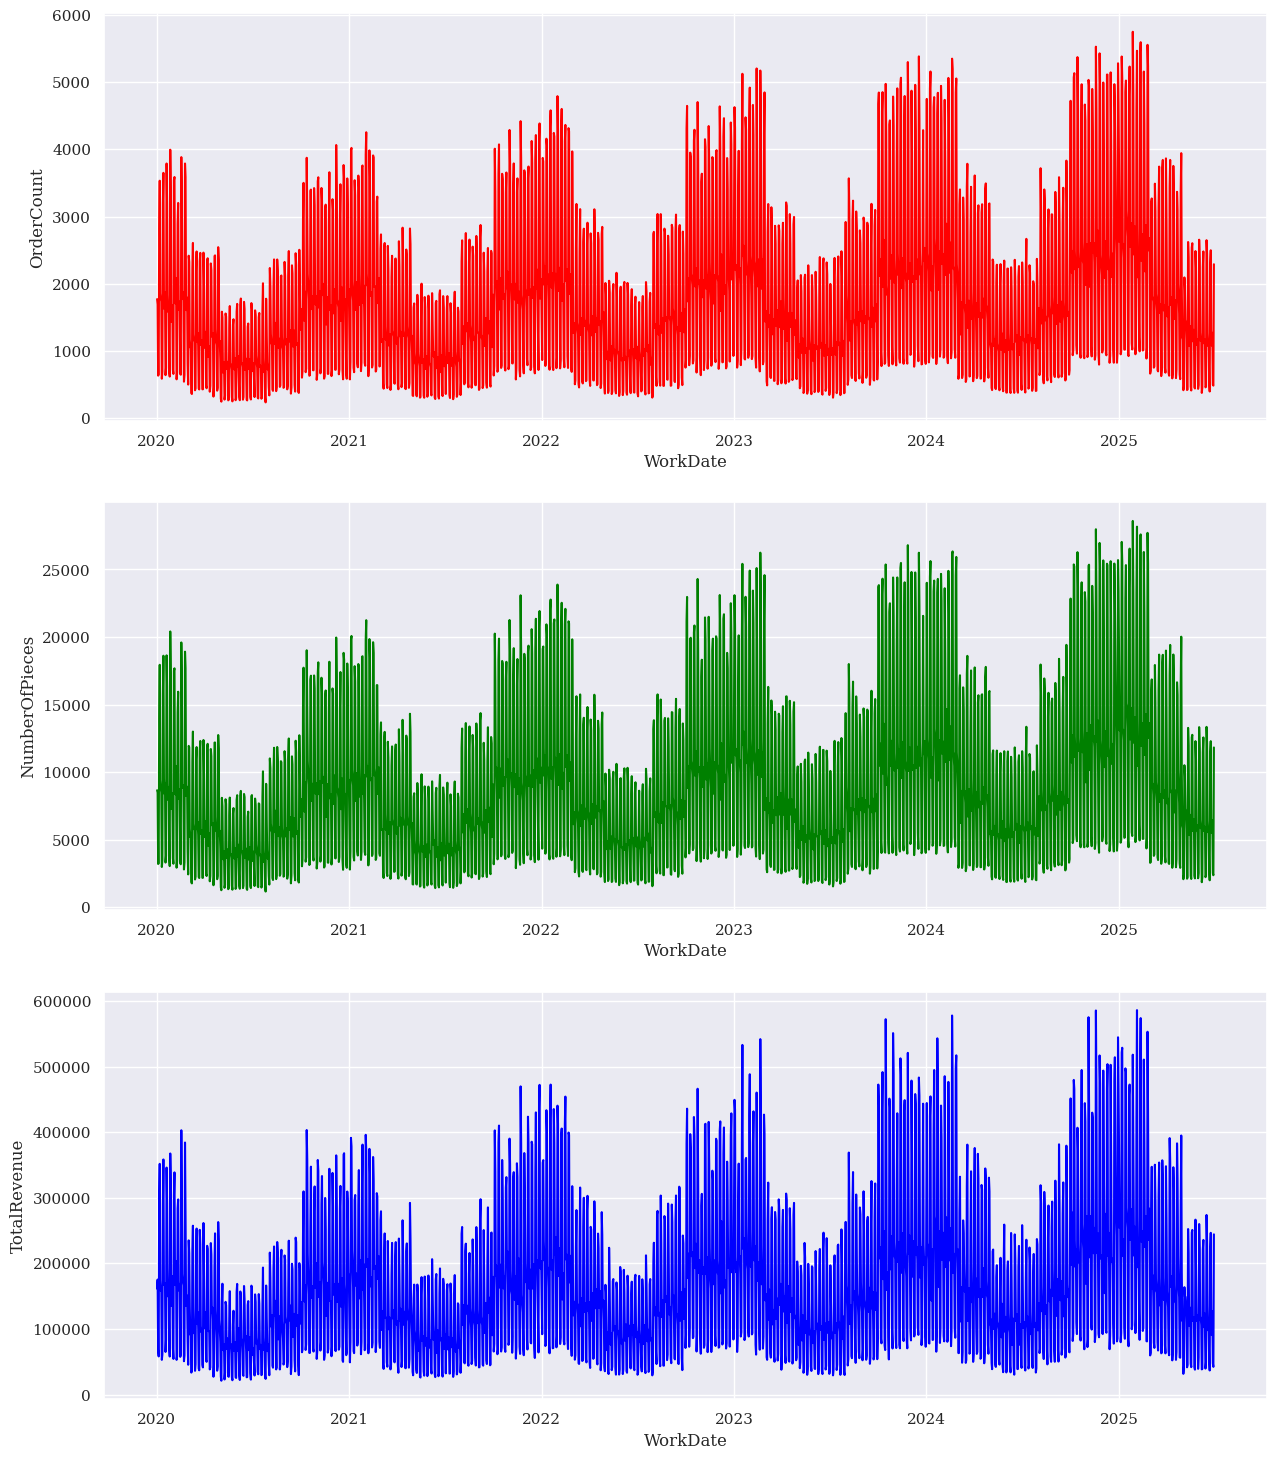

In [61]:
# plot the time evolution graphs
#df_bydate.set_index('WorkDate',inplace=True)
fig_ts, ax_ts = plt.subplots(3,1,figsize=(15,18))
sns.lineplot(data=df_bydate, x=df_bydate.index, y='OrderCount',ax=ax_ts[0],color='red')
sns.lineplot(data=df_bydate, x=df_bydate.index, y='NumberOfPieces',ax=ax_ts[1],color='green')
sns.lineplot(data=df_bydate, x=df_bydate.index, y='TotalRevenue',ax=ax_ts[2],color='blue')

<Axes: xlabel='WorkDate', ylabel='OrderCount'>

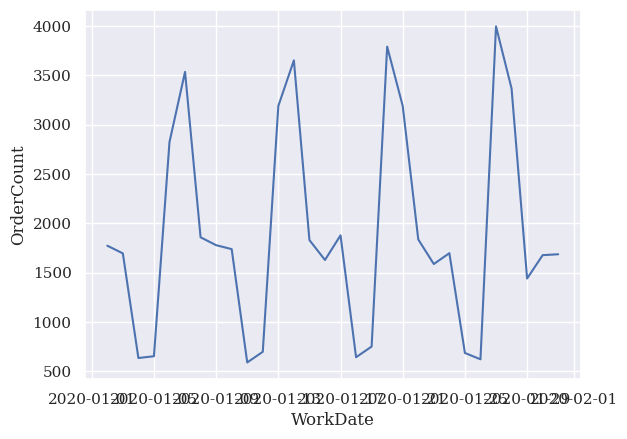

In [62]:
df_bydate_short = df_bydate.head(30)
sns.lineplot(data=df_bydate_short, x=df_bydate_short.index, y='OrderCount')

There are multi-seasonal effects in the time series for all three targets with 1-year and 1-week periods. In particular, the delivery gets peaked at the beginning and the end of years (typically from Oct-Feb) and on Monday-Tuesday, and becomes less vibrant in the middle of the year and in the weekend. Let's now remove (decompose) these seasonal effects to see the trend. We use the **Multiple Seasonal-Trend decomposition using LOESS (MSTL)** for daily data with periods 7 (weekly) and 365 (yearly).

In [63]:
order_decompose = MSTL(df_bydate['OrderCount'], periods = [7,365])
order_decompose_result = order_decompose.fit()
#print(order_decompose_result.trend)

npiece_decompose = MSTL(df_bydate['NumberOfPieces'], periods = [7,365])
npiece_decompose_result = npiece_decompose.fit()
#print(npiece_decompose_result.trend)

revenue_decompose = MSTL(df_bydate['TotalRevenue'], periods = [7,365])
revenue_decompose_result = revenue_decompose.fit()

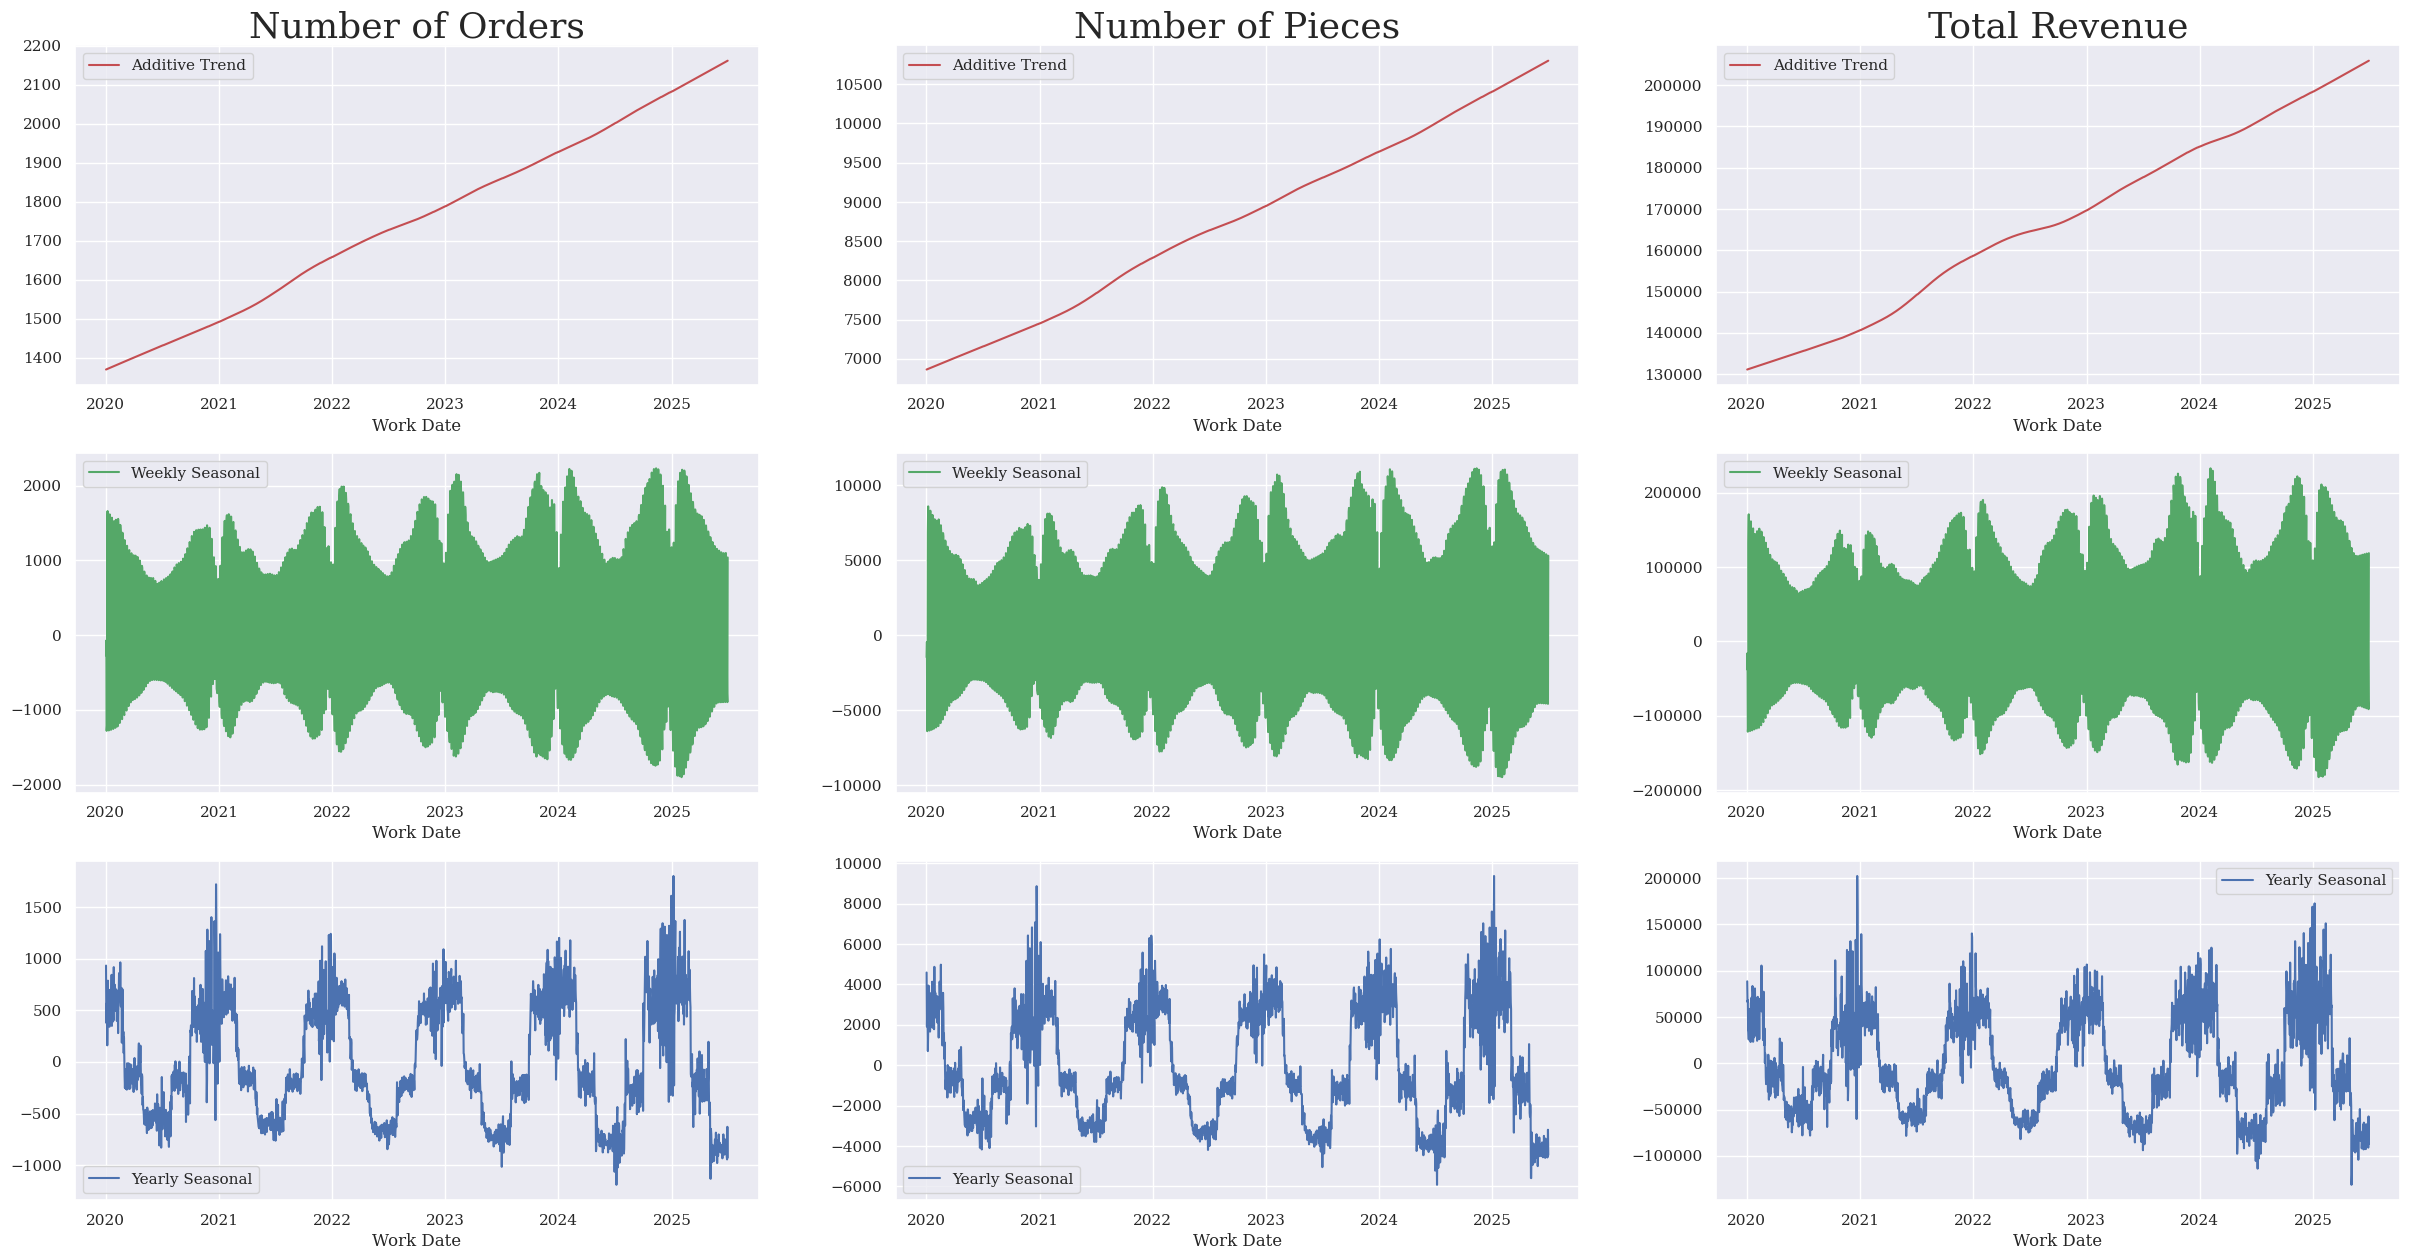

In [64]:
fig_seasonal, ax_seasonal = plt.subplots(3,3,figsize=(30,15))
#
ax_seasonal[0][0].plot(order_decompose_result.trend, color='r', label='Additive Trend')
ax_seasonal[1][0].plot(order_decompose_result.seasonal["seasonal_7"], color='g', label='Weekly Seasonal')
ax_seasonal[2][0].plot(order_decompose_result.seasonal["seasonal_365"], color='b', label='Yearly Seasonal')
ax_seasonal[0][0].legend()
ax_seasonal[1][0].legend()
ax_seasonal[2][0].legend()
ax_seasonal[0][0].set_title("Number of Orders",fontsize=26)
#
ax_seasonal[0][1].plot(npiece_decompose_result.trend, color='r', label='Additive Trend')
ax_seasonal[1][1].plot(npiece_decompose_result.seasonal["seasonal_7"], color='g', label='Weekly Seasonal')
ax_seasonal[2][1].plot(npiece_decompose_result.seasonal["seasonal_365"], color='b', label='Yearly Seasonal')
ax_seasonal[0][1].legend()
ax_seasonal[1][1].legend()
ax_seasonal[2][1].legend()
ax_seasonal[0][1].set_title("Number of Pieces",fontsize=26)
#
ax_seasonal[0][2].plot(revenue_decompose_result.trend, color='r', label='Additive Trend')
ax_seasonal[1][2].plot(revenue_decompose_result.seasonal["seasonal_7"], color='g', label='Weekly Seasonal')
ax_seasonal[2][2].plot(revenue_decompose_result.seasonal["seasonal_365"], color='b', label='Yearly Seasonal')
ax_seasonal[0][2].legend()
ax_seasonal[1][2].legend()
ax_seasonal[2][2].legend()
ax_seasonal[0][2].set_title("Total Revenue",fontsize=26)
for i in range(3):
    for j in range(3):
        ax_seasonal[i][j].set_xlabel('Work Date')


We see that all three properties exhibit approximately linear increasing trend, which is augumented by seasonal effects. 

### 1c. Anomaly detection using MSTL results: 
We set the threshold to 2.5 sigmas to identify the ouliers

In [65]:
import math
# Set threshold (the number of sigmas) and calculate the confidence level
threshold = 2.5
cl = round(100*math.erf(threshold/np.sqrt(2)),1)     
print(f"Threshold: {threshold} sigmas, corresponding to {cl}% CL")

# order
order_resid_mean = order_decompose_result.resid.mean()
order_resid_std = order_decompose_result.resid.std()
order_lower_bound = order_resid_mean - threshold*order_resid_std
order_upper_bound = order_resid_mean + threshold*order_resid_std

# npiece
npiece_resid_mean = npiece_decompose_result.resid.mean()
npiece_resid_std = npiece_decompose_result.resid.std()
npiece_lower_bound = npiece_resid_mean - threshold*npiece_resid_std
npiece_upper_bound = npiece_resid_mean + threshold*npiece_resid_std

# revenue
revenue_resid_mean = revenue_decompose_result.resid.mean()
revenue_resid_std = revenue_decompose_result.resid.std()
revenue_lower_bound = revenue_resid_mean - threshold*revenue_resid_std
revenue_upper_bound = revenue_resid_mean + threshold*revenue_resid_std


Threshold: 2.5 sigmas, corresponding to 98.8% CL


Text(0.5, 1.05, '98.8% CL (2.5$\\sigma$)')

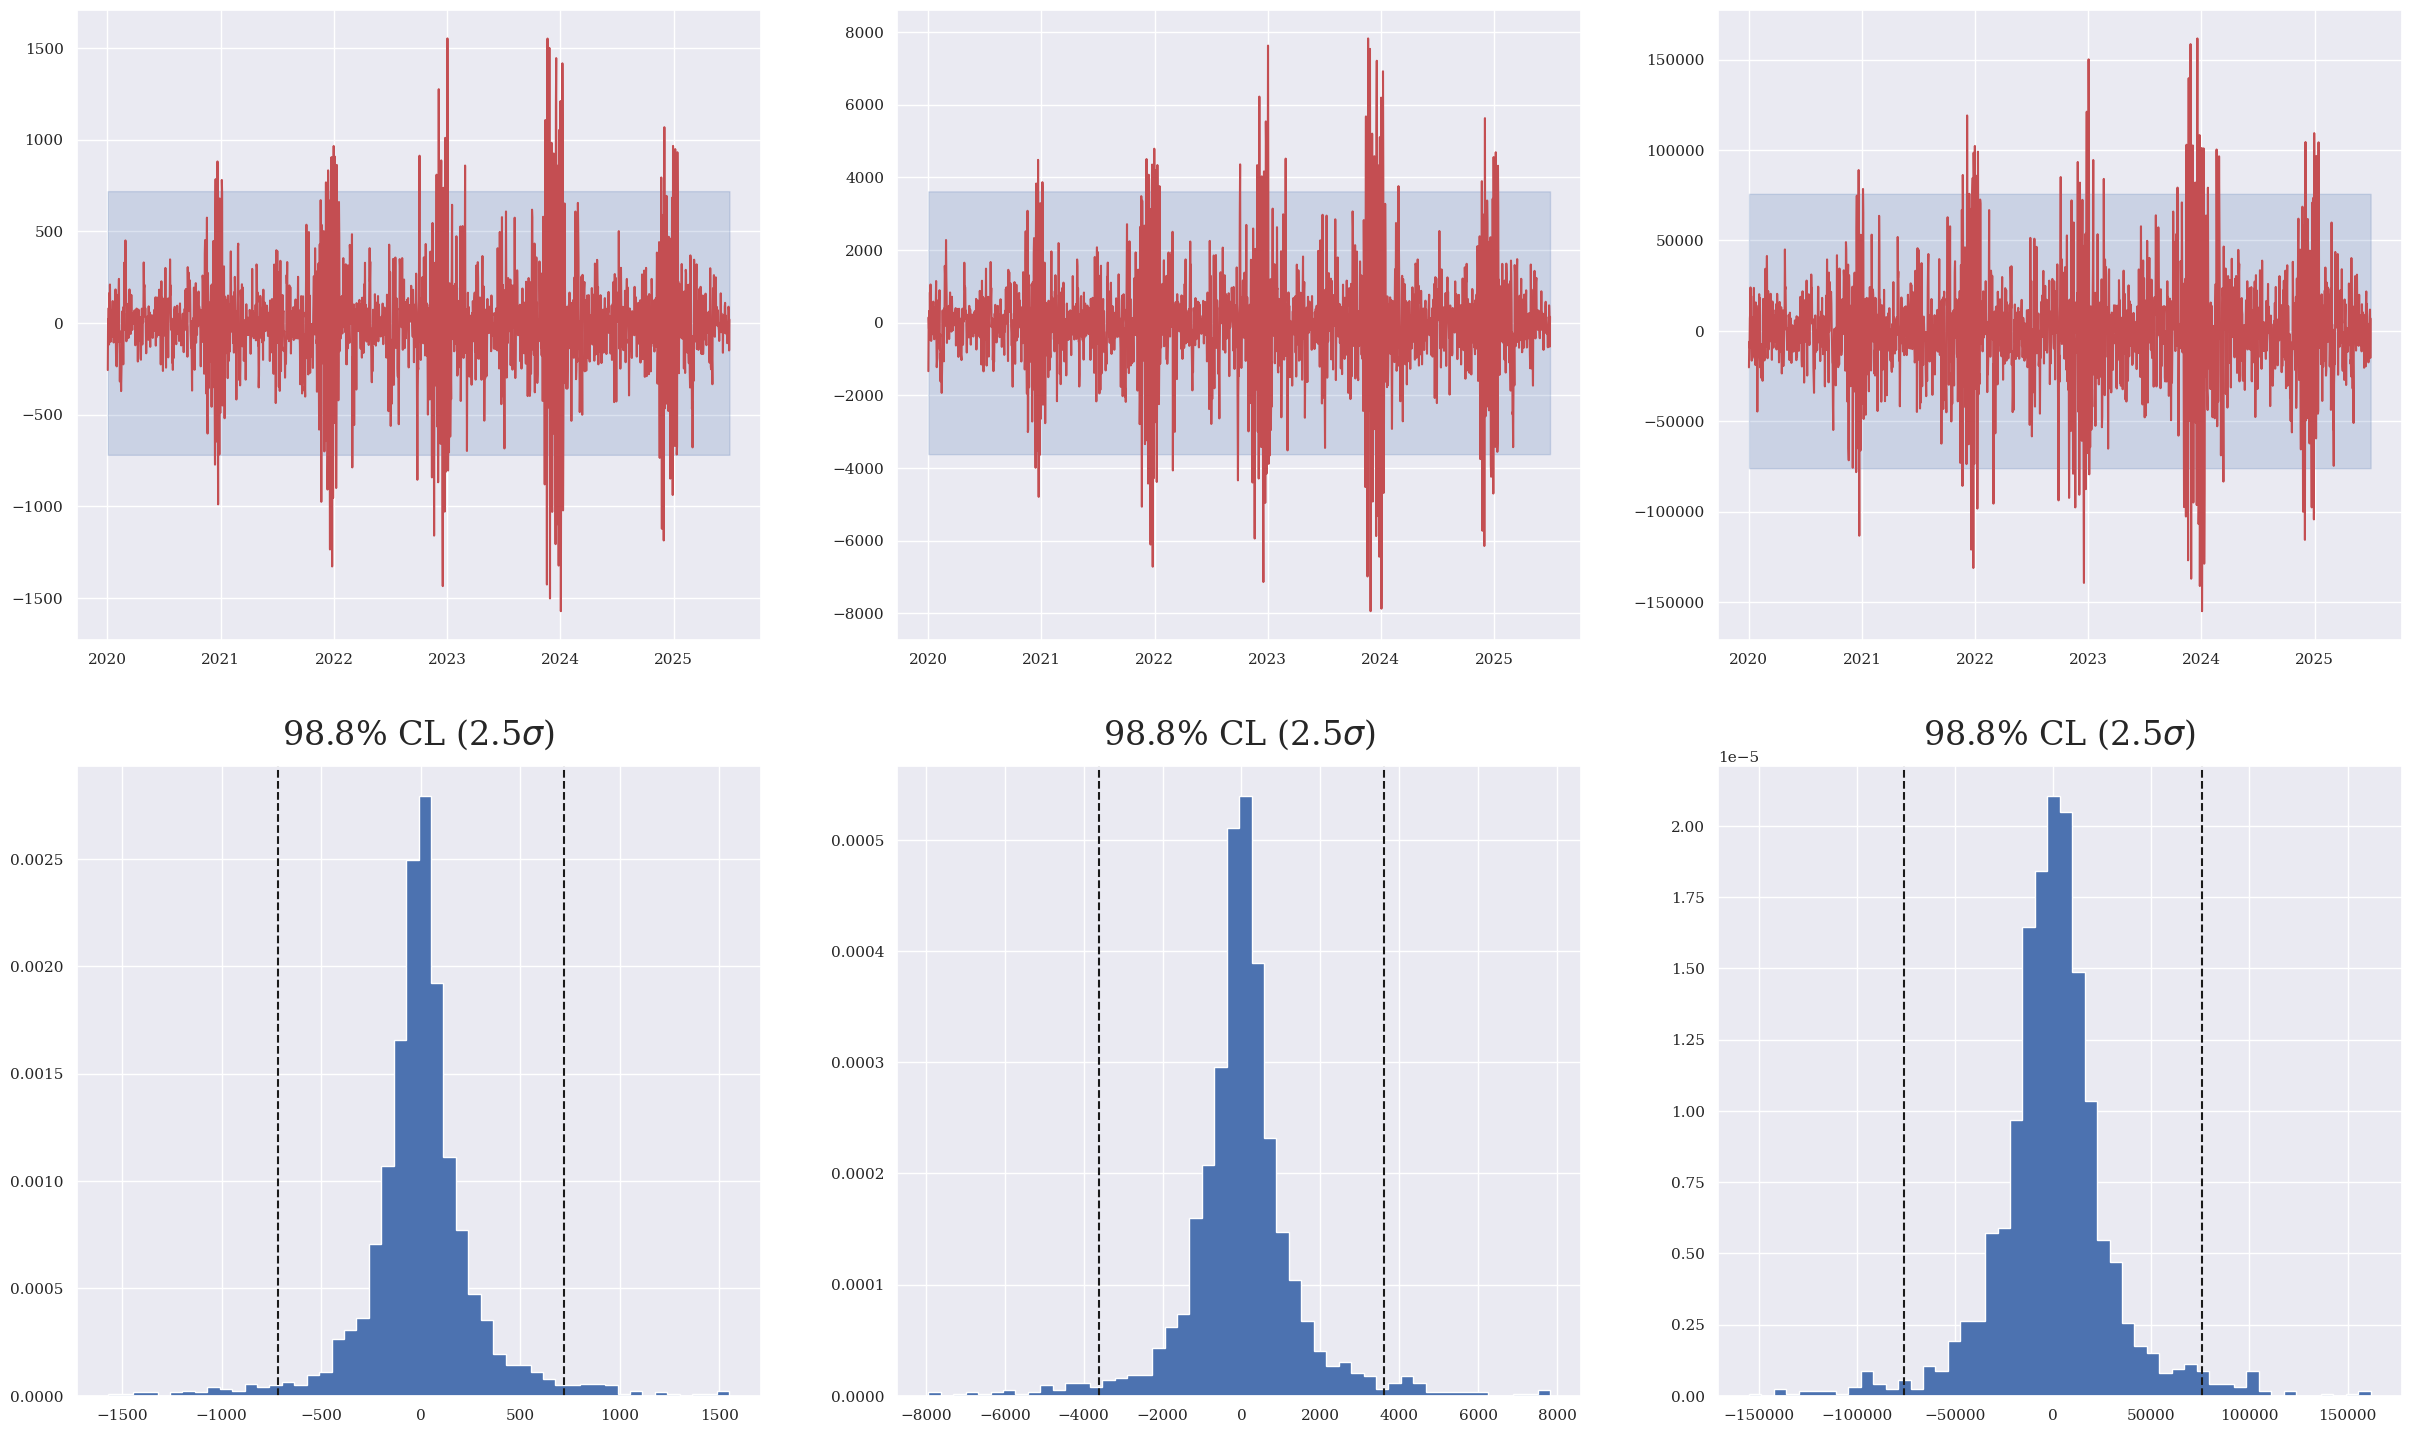

In [66]:
# Looking at the residual distributions
fig_residual, ax_residual = plt.subplots(2,3,figsize=(30,18))
ax_residual[0][0].plot(order_decompose_result.resid, color='r', label='Residual')
ax_residual[0][1].plot(npiece_decompose_result.resid, color='r', label='Residual')
ax_residual[0][2].plot(revenue_decompose_result.resid, color='r', label='Residual')
ax_residual[0][0].fill_between(order_decompose_result.resid.index,order_lower_bound, order_upper_bound, color='b',alpha=0.2)
ax_residual[0][1].fill_between(npiece_decompose_result.resid.index,npiece_lower_bound, npiece_upper_bound, color='b',alpha=0.2)
ax_residual[0][2].fill_between(revenue_decompose_result.resid.index,revenue_lower_bound, revenue_upper_bound, color='b',alpha=0.2)

ax_residual[1][0].hist(order_decompose_result.resid, bins=50, density=True, histtype='stepfilled')
ax_residual[1][1].hist(npiece_decompose_result.resid, bins=50, density=True, histtype='stepfilled')
ax_residual[1][2].hist(revenue_decompose_result.resid, bins=50, density=True, histtype='stepfilled')
ax_residual[1][0].axvline(order_lower_bound, ls='--', color='k')
ax_residual[1][0].axvline(order_upper_bound, ls='--', color='k')
ax_residual[1][1].axvline(npiece_lower_bound, ls='--', color='k')
ax_residual[1][1].axvline(npiece_upper_bound, ls='--', color='k')
ax_residual[1][2].axvline(revenue_lower_bound, ls='--', color='k')
ax_residual[1][2].axvline(revenue_upper_bound, ls='--', color='k')

ax_residual[1][0].text(0.5, 1.05, f'{cl}% CL ({threshold}$\sigma$)', horizontalalignment='center',
     verticalalignment='center', transform=ax_residual[1][0].transAxes)
ax_residual[1][1].text(0.5, 1.05, f'{cl}% CL ({threshold}$\sigma$)', horizontalalignment='center',
     verticalalignment='center', transform=ax_residual[1][1].transAxes)
ax_residual[1][2].text(0.5, 1.05, f'{cl}% CL ({threshold}$\sigma$)', horizontalalignment='center',
     verticalalignment='center', transform=ax_residual[1][2].transAxes)

In [67]:
# Find out the outliers with 2.5 sigmas threshold
order_anomalies = df_bydate['OrderCount'][
    (order_decompose_result.resid < order_lower_bound) | (order_decompose_result.resid > order_upper_bound)]
npiece_anomalies = df_bydate['NumberOfPieces'][
    (npiece_decompose_result.resid < npiece_lower_bound) | (npiece_decompose_result.resid > npiece_upper_bound)]
revenue_anomalies = df_bydate['TotalRevenue'][
    (revenue_decompose_result.resid < revenue_lower_bound) | (revenue_decompose_result.resid > revenue_upper_bound)]

# Find out the demand spikes with 2.5 sigmas threshold
order_spikes = df_bydate['OrderCount'][(order_decompose_result.resid > order_upper_bound)]
npiece_spikes = df_bydate['NumberOfPieces'][(npiece_decompose_result.resid > npiece_upper_bound)]
revenue_spikes = df_bydate['TotalRevenue'][(revenue_decompose_result.resid > revenue_upper_bound)]

# Considering the spikes in number of orders
order_spikes = pd.DataFrame(order_spikes)
print(order_spikes)


            OrderCount
WorkDate              
2020-12-15        3481
2020-12-21        3767
2021-01-04        3995
2021-12-06        3571
2021-12-13        4125
2021-12-23        2210
2021-12-24        1729
2021-12-27        4113
2021-12-31        2066
2022-01-03        3873
2022-01-04        3819
2022-01-10        4159
2022-10-04        4647
2022-11-28        3965
2022-12-05        4640
2022-12-13        4464
2022-12-20        3410
2022-12-26        4400
2022-12-27        4075
2023-01-02        4628
2023-01-03        4320
2023-02-28        4848
2023-11-14        5066
2023-11-21        4794
2023-11-27        5299
2023-12-04        4873
2023-12-11        4960
2023-12-18        5384
2023-12-19        4456
2023-12-26        4286
2023-12-29        2534
2024-01-02        4751
2024-01-08        4900
2024-01-09        5159
2024-11-22        2208
2024-12-02        4995
2024-12-30        5281
2025-01-06        5382
2025-01-13        4851


Looking at these outliers, one can see that there were usually demand spikes around the Thanksgiving, between Christmas and New Year Eve, and in few days after the New Year. 

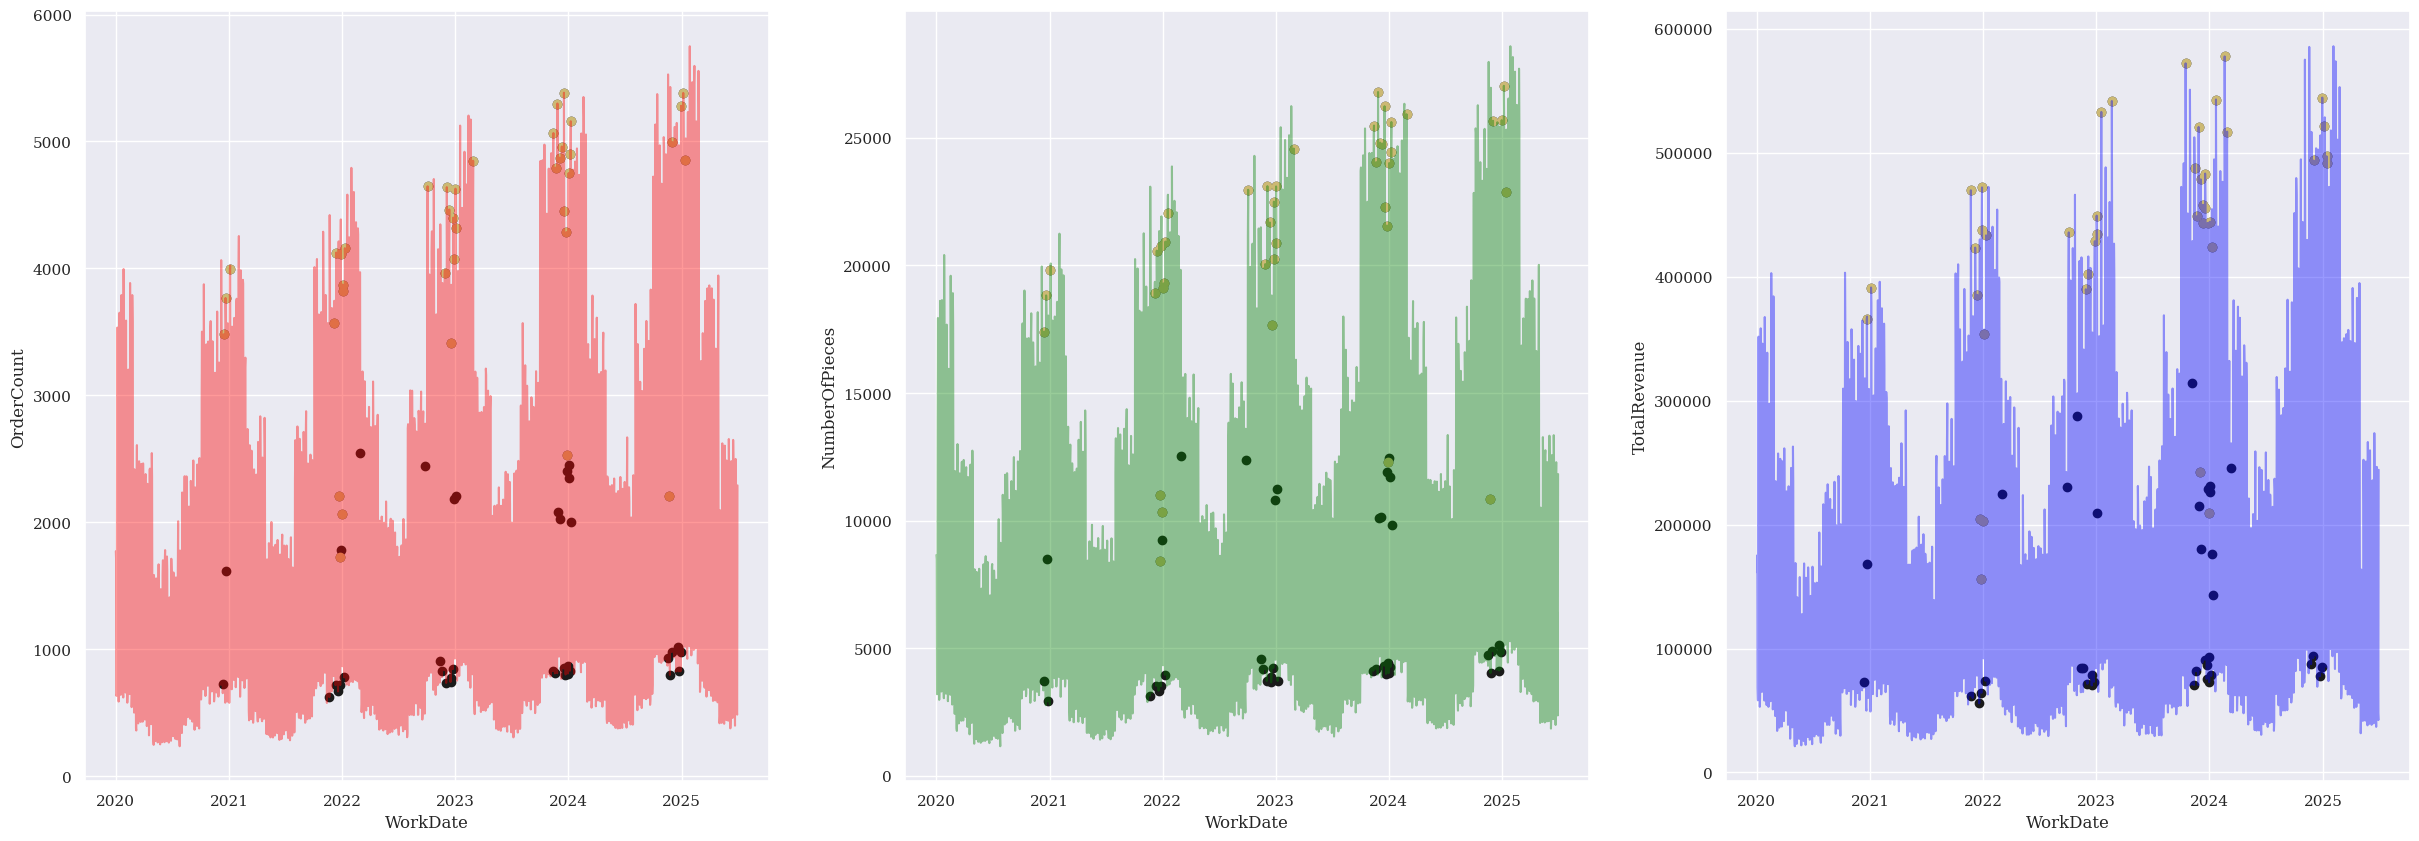

In [68]:
# Plot the outliers on the time series
fig_ts_outliers, ax_ts_outliers = plt.subplots(1,3,figsize=(30,10))
sns.lineplot(data=df_bydate, x=df_bydate.index, y='OrderCount',ax=ax_ts_outliers[0],color='red',alpha=0.4)
sns.lineplot(data=df_bydate, x=df_bydate.index, y='NumberOfPieces',ax=ax_ts_outliers[1],color='green',alpha=0.4)
sns.lineplot(data=df_bydate, x=df_bydate.index, y='TotalRevenue',ax=ax_ts_outliers[2],color='blue',alpha=0.4)

ax_ts_outliers[0].scatter(y=order_anomalies, x=order_anomalies.index, c='k')
ax_ts_outliers[1].scatter(y=npiece_anomalies, x=npiece_anomalies.index, c='k')
ax_ts_outliers[2].scatter(y=revenue_anomalies, x=revenue_anomalies.index, c='k')

ax_ts_outliers[0].scatter(y=order_spikes, x=order_spikes.index, c='y')
ax_ts_outliers[1].scatter(y=npiece_spikes, x=npiece_spikes.index, c='y')
ax_ts_outliers[2].scatter(y=revenue_spikes, x=revenue_spikes.index, c='y')

### 1d. Overall distributions 
Let us know plot the distributions of three indicators.

<Axes: ylabel='TotalRevenue'>

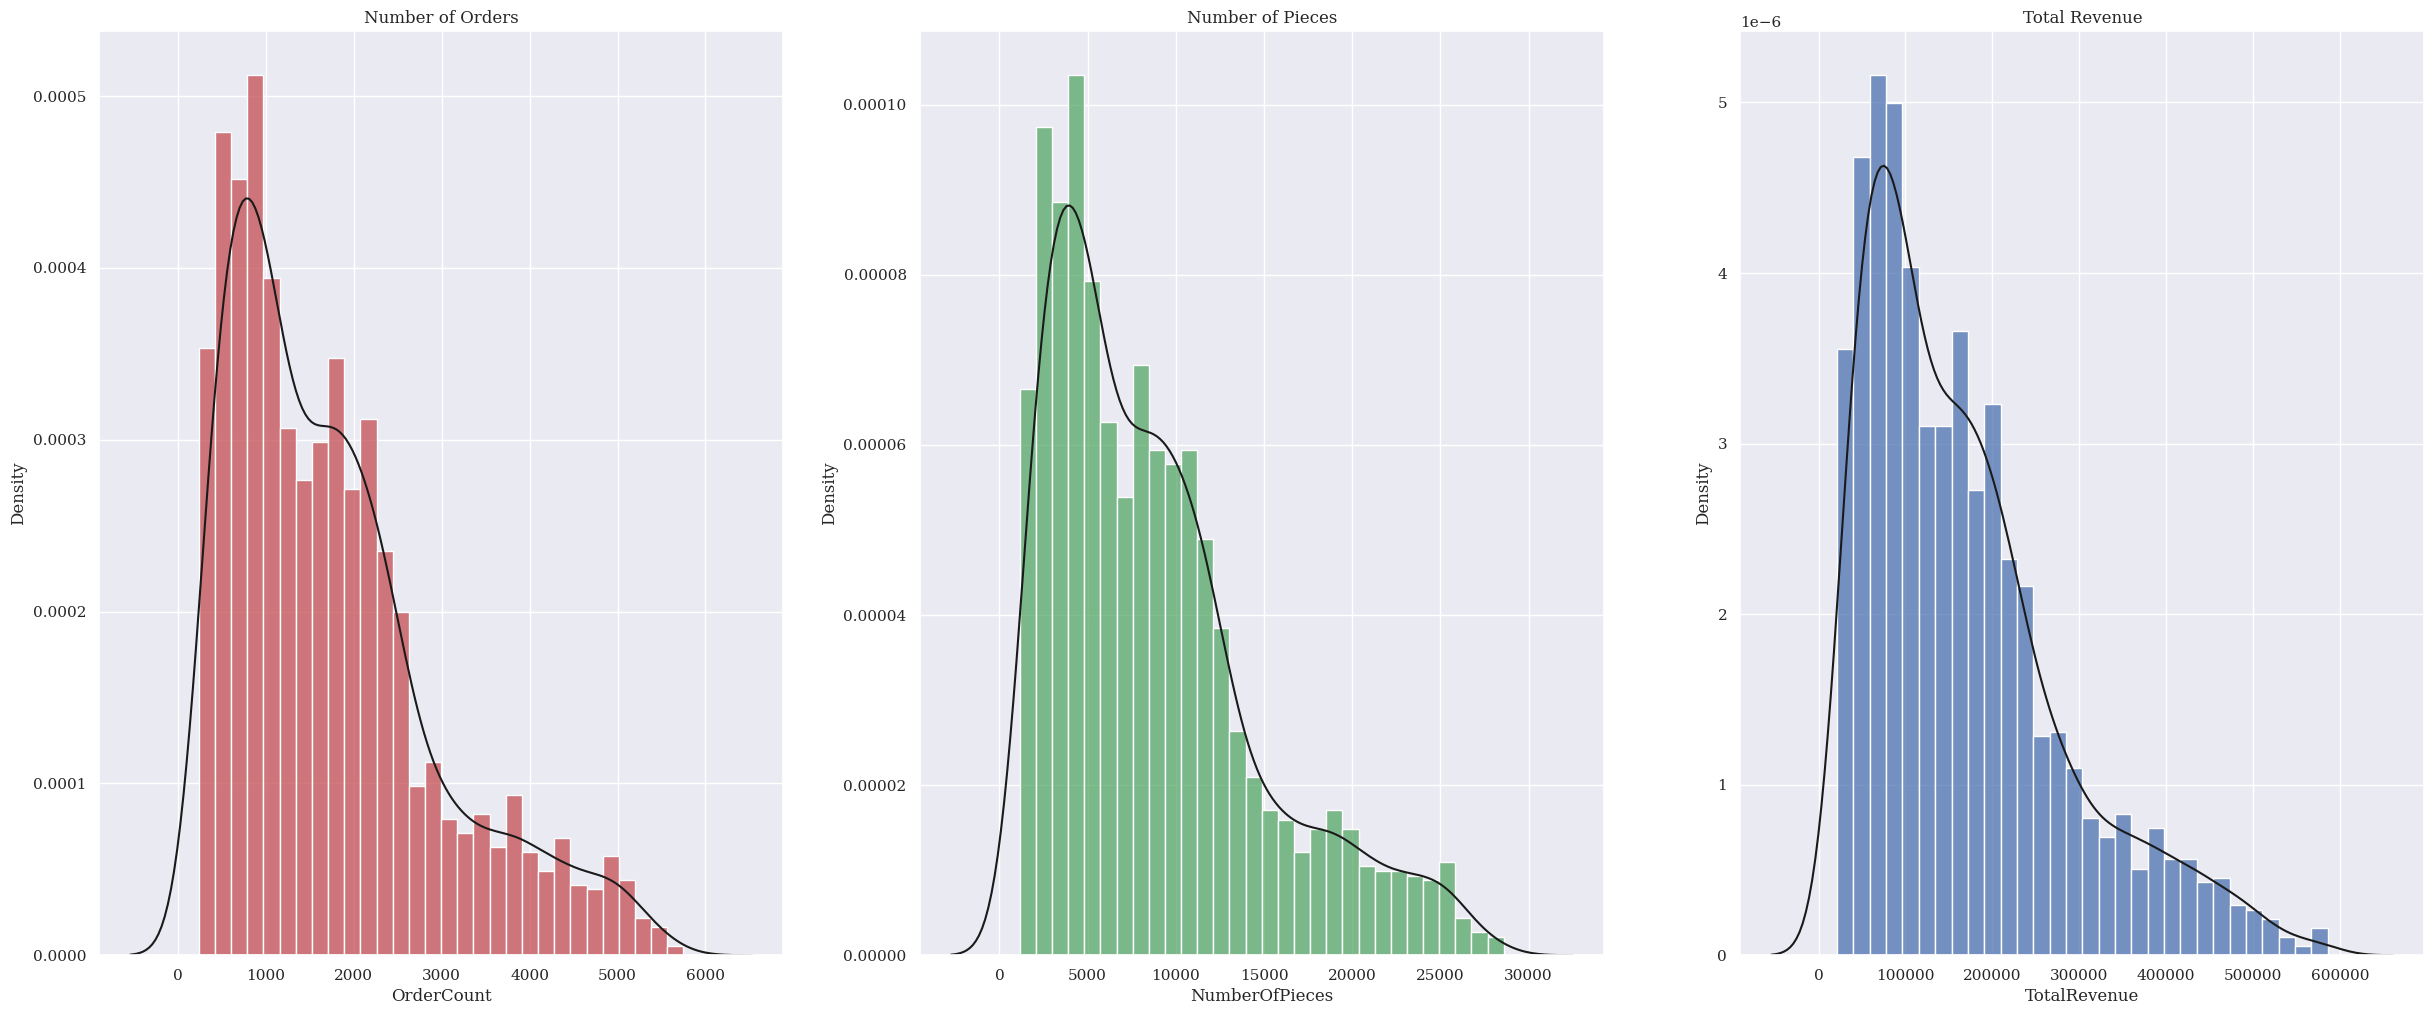

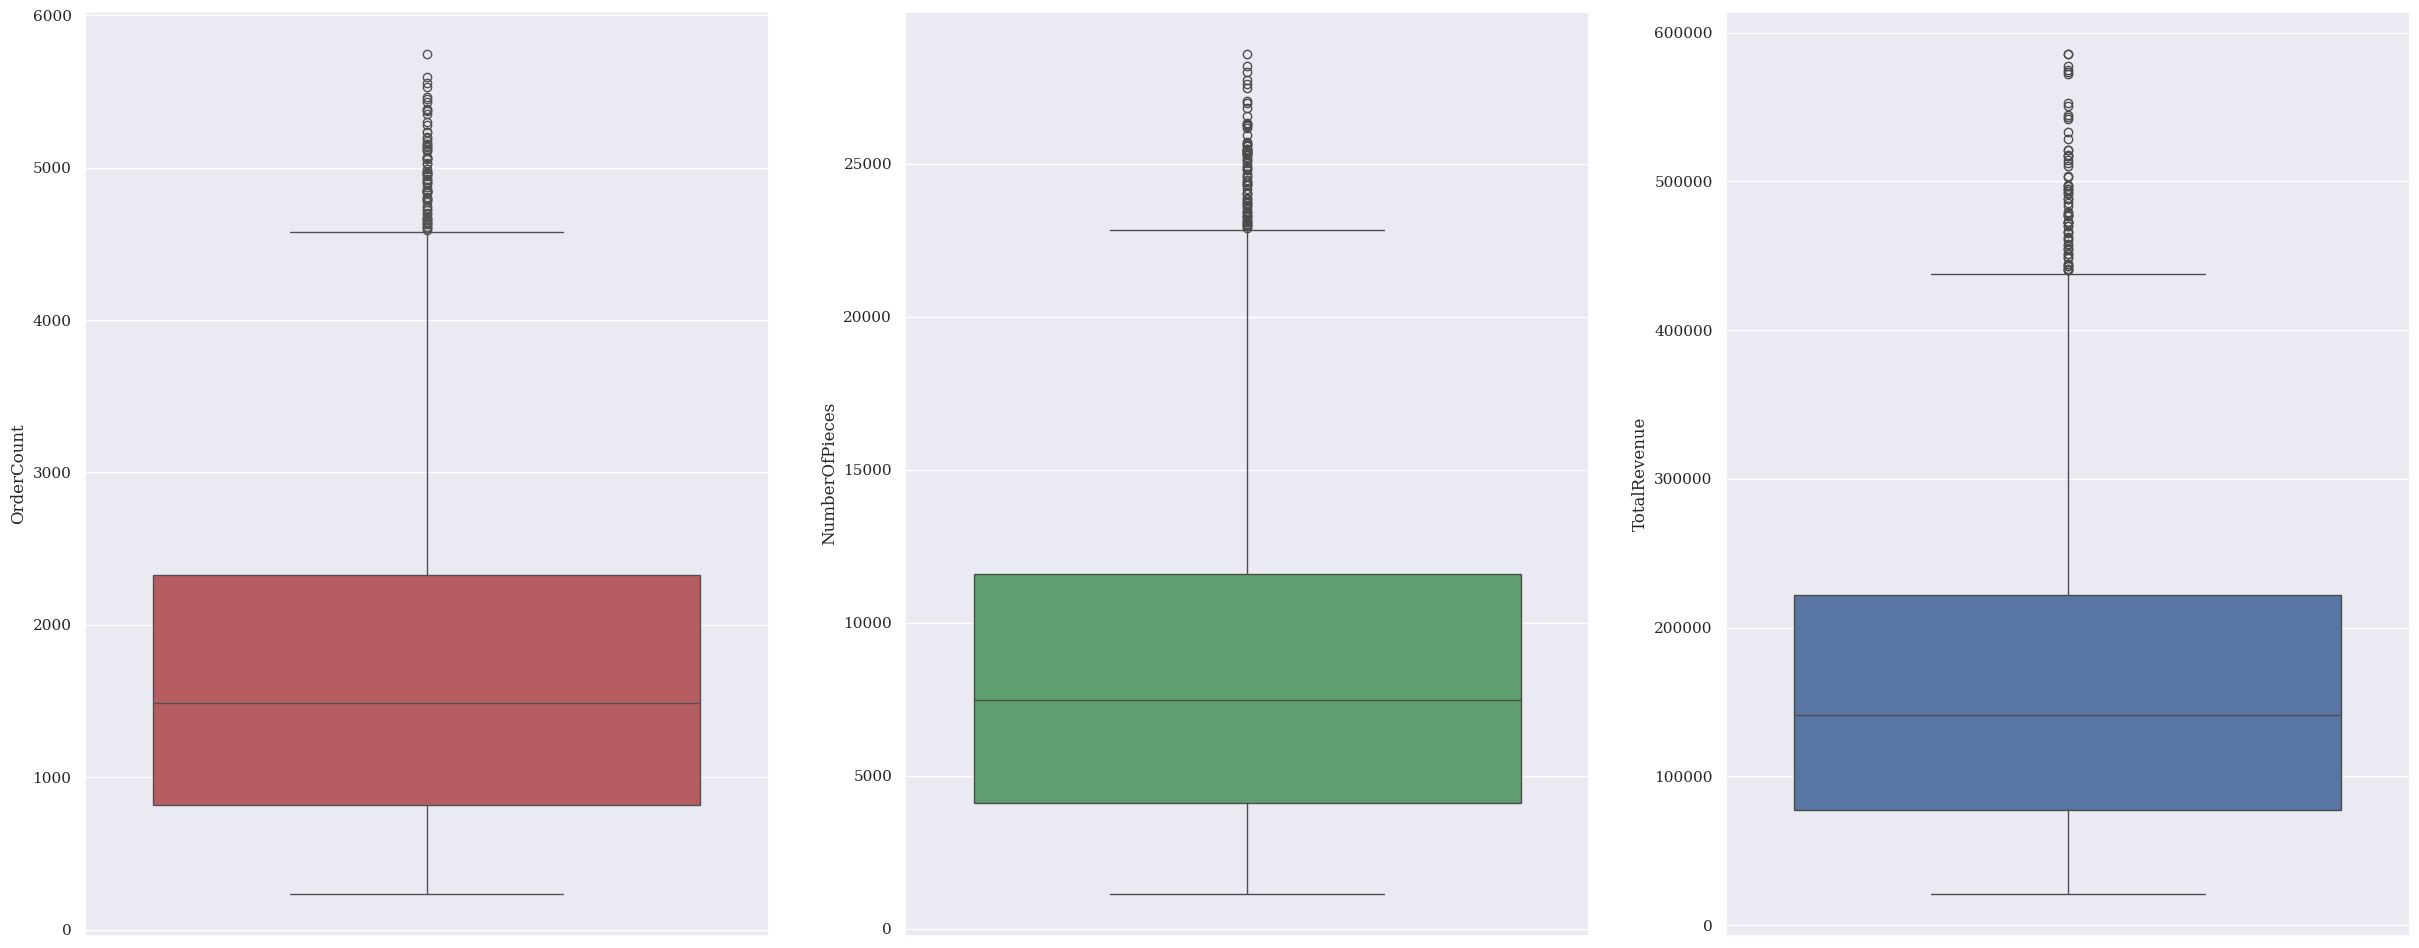

In [69]:
# Histogram
fig_bydate_hist, ax_bydate_hist = plt.subplots(1,3,figsize=(30,12))
sns.histplot(data=df_bydate, x="OrderCount", stat = 'density', bins=30, kde=False, ax = ax_bydate_hist[0],color='r')
sns.kdeplot(data=df_bydate, x="OrderCount",ax = ax_bydate_hist[0],color='k')
sns.histplot(data=df_bydate, x="NumberOfPieces", stat = 'density', bins=30, kde=False, ax = ax_bydate_hist[1],color='g')
sns.kdeplot(data=df_bydate, x="NumberOfPieces",ax = ax_bydate_hist[1],color='k')
sns.histplot(data=df_bydate, x="TotalRevenue", stat = 'density', bins=30, kde=False, ax = ax_bydate_hist[2],color='b')
sns.kdeplot(data=df_bydate, x="TotalRevenue",ax = ax_bydate_hist[2],color='k')
ax_bydate_hist[0].set_title("Number of Orders")
ax_bydate_hist[1].set_title("Number of Pieces")
ax_bydate_hist[2].set_title("Total Revenue")

# boxplot
fig_bydate_box, ax_bydate_box = plt.subplots(1,3,figsize=(30,12))
sns.boxplot(data=df_bydate, y="OrderCount", ax = ax_bydate_box[0],color='r')
sns.boxplot(data=df_bydate, y="NumberOfPieces", ax = ax_bydate_box[1],color='g')
sns.boxplot(data=df_bydate, y="TotalRevenue", ax = ax_bydate_box[2],color='b')

We see that their distributions have a similar shape, which is right skewed. There is a non-negligible number of outliers which are significantly distant from the upper whisker. Some of these indicates demand spikes in the time series. 

### 1e. Analysis the distribution by date of week and by season

In [70]:
# add season, month, and day of week columns to the dataset
seasons_partition = {
    'Winter':[12, 1, 2],
    'Spring':[3, 4, 5],
    'Summer':[6, 7, 8],
    'Autumn':[9, 10, 11]
}
def keyLookup(requiredVal):
    for key, val in seasons_partition.items():
        if requiredVal in val:
            return key
def partLookup(requiredVal):
    if (requiredVal == 0) or (requiredVal == 1):
        return 'BeginWeek'
    elif (requiredVal == 3) or (requiredVal == 2) or (requiredVal == 4):
        return 'MidWeek'
    else:
        return 'Weekend'

df_bydate['DateOfWeek'] = df_bydate.index.dayofweek
df_bydate['IsWeekend'] = (df_bydate['DateOfWeek'] == 5) | (df_bydate['DateOfWeek'] == 6)
df_bydate['Month'] = df_bydate.index.month
df_bydate['Year'] = df_bydate.index.year
df_bydate['Season'] = df_bydate['Month'].map(keyLookup)
df_bydate['WeekPart'] = df_bydate['DateOfWeek'].map(partLookup)
print(df_bydate.head())

days_of_week = df_bydate['DateOfWeek'].unique().tolist()
seasons = df_bydate['Season'].unique().tolist()

            OrderCount  NumberOfPieces  TotalRevenue  DateOfWeek  IsWeekend  Month  Year  Season   WeekPart
WorkDate                                                                                                   
2020-01-02        1772            8653     161607.16           3      False      1  2020  Winter    MidWeek
2020-01-03        1694            8483     175312.27           4      False      1  2020  Winter    MidWeek
2020-01-04         633            3195      68512.12           5       True      1  2020  Winter    Weekend
2020-01-05         651            3244      58218.17           6       True      1  2020  Winter    Weekend
2020-01-06        2823           13964     306535.70           0      False      1  2020  Winter  BeginWeek


   DateOfWeek  OrderCount  NumberOfPieces  TotalRevenue   WeekPart
0           0      903064         4513708   86542687.71  BeginWeek
1           1      895309         4484458   84962400.10  BeginWeek
2           2      442628         2212198   42224203.84    MidWeek
3           3      437532         2185540   41566518.29    MidWeek
4           4      446889         2230787   42519755.41    MidWeek
5           5      172063          862219   16439742.73    Weekend
6           6      172982          864571   16480949.01    Weekend
   IsWeekend  OrderCount  NumberOfPieces  TotalRevenue
0      False     3125422        15626691  2.978156e+08
1       True      345045         1726790  3.292069e+07


<Axes: xlabel='IsWeekend', ylabel='TotalRevenue'>

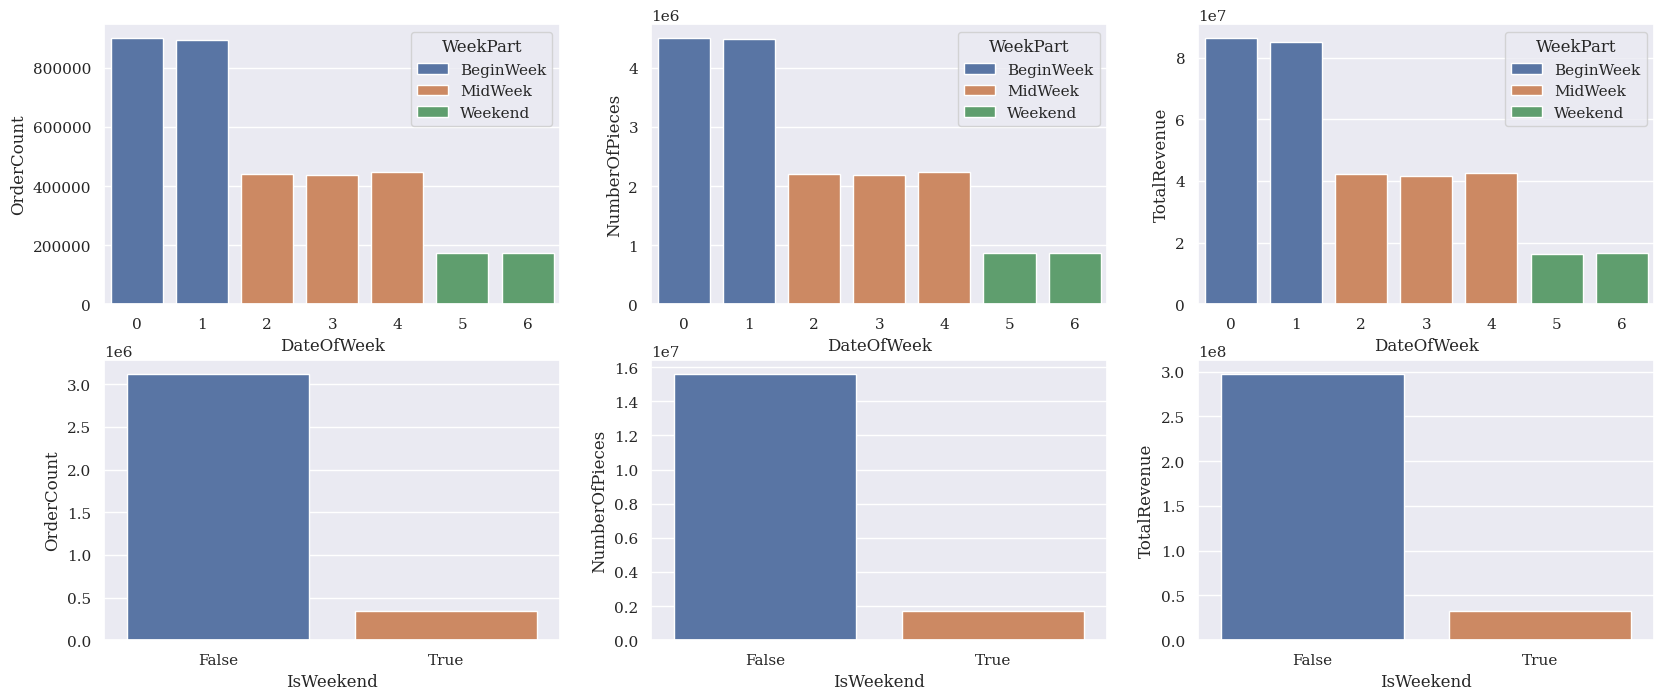

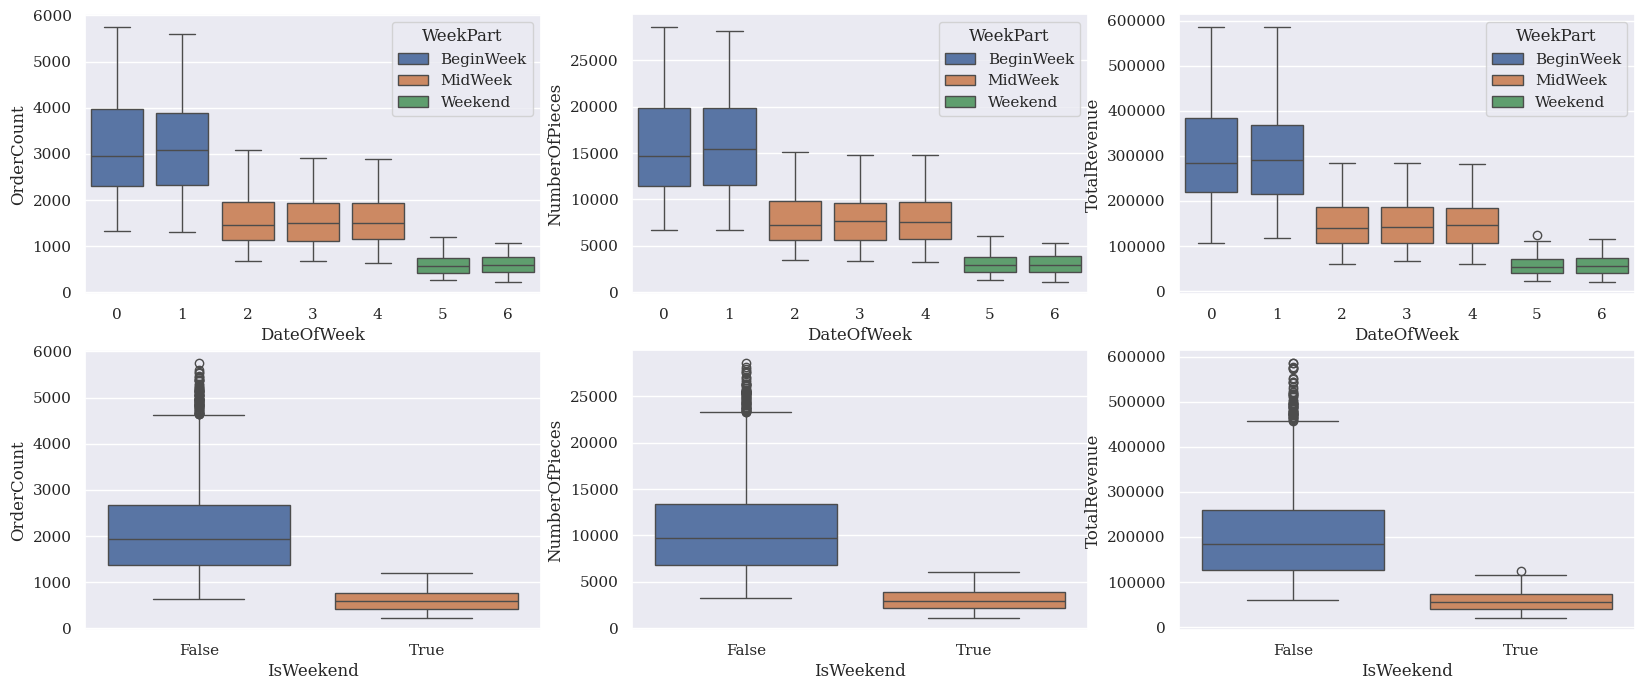

In [71]:
# Group by date of week and by IsWeekend
df_bydate_dow = df_bydate.groupby(by=['DateOfWeek'],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_bydate_iw = df_bydate.groupby(by=['IsWeekend'],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_bydate_dow['WeekPart'] = df_bydate_dow['DateOfWeek'].map(partLookup)
print(df_bydate_dow.head(10))
print(df_bydate_iw.head())

# Bar Plot
fig_bydate_week_bar, ax_bydate_week_bar = plt.subplots(2,3,figsize=(20,8))
sns.barplot(data = df_bydate_dow, x = 'DateOfWeek' , y = 'OrderCount', ax = ax_bydate_week_bar[0][0], hue = "WeekPart")
sns.barplot(data = df_bydate_dow, x = 'DateOfWeek', y = 'NumberOfPieces', ax = ax_bydate_week_bar[0][1], hue = "WeekPart")
sns.barplot(data = df_bydate_dow, x = 'DateOfWeek', y = 'TotalRevenue', ax = ax_bydate_week_bar[0][2], hue = "WeekPart")

sns.barplot(data = df_bydate_iw, x = 'IsWeekend', y = 'OrderCount', ax = ax_bydate_week_bar[1][0], hue = 'IsWeekend',legend=False)
sns.barplot(data = df_bydate_iw, x = 'IsWeekend', y = 'NumberOfPieces', ax = ax_bydate_week_bar[1][1], hue = 'IsWeekend',legend=False)
sns.barplot(data = df_bydate_iw, x = 'IsWeekend', y = 'TotalRevenue', ax = ax_bydate_week_bar[1][2], hue = 'IsWeekend',legend=False)

# Box plot
fig_bydate_week_box, ax_bydate_week_box = plt.subplots(2,3,figsize=(20,8))
sns.boxplot(data=df_bydate, x='DateOfWeek', y='OrderCount', ax = ax_bydate_week_box[0][0],hue="WeekPart")
sns.boxplot(data=df_bydate, x='DateOfWeek', y='NumberOfPieces', ax = ax_bydate_week_box[0][1],hue="WeekPart")
sns.boxplot(data=df_bydate, x='DateOfWeek', y='TotalRevenue', ax = ax_bydate_week_box[0][2],hue="WeekPart")

sns.boxplot(data=df_bydate, x='IsWeekend', y='OrderCount', ax = ax_bydate_week_box[1][0], hue='IsWeekend',legend=False)
sns.boxplot(data=df_bydate, x='IsWeekend', y='NumberOfPieces', ax = ax_bydate_week_box[1][1], hue='IsWeekend',legend=False)
sns.boxplot(data=df_bydate, x='IsWeekend', y='TotalRevenue', ax = ax_bydate_week_box[1][2], hue='IsWeekend',legend=False)

The above plots indicate that we can partition the weekly delivery into two or three sectors:
- Firstly, we can partition the weekly delivery into three distinct ranges of the week: BeginWeek (Mon-Tue), MidWeek (Wed-Fri), and Weekend (Sat-Sun). The delivery decreases from BeginWeek to Weekend, and the total delivery value of the BeginWeek is approximately equal to the total value of the other days in total. This indicate that the BeginWeek delivery dominates over the other ranges of delivery in a week. In addition, all days in each range have very similar total delivery values and very similar distributions. 
- One can also divide the weekly delivery into two pools (Weekday and Weekend). From the above discussion, the weekday delivery should dominate over the weekend delivery. This is indeed the case: the delivery in the weekend is about ten times larger than during the weekday.

These properties can be expected from the time series visualization.

<Axes: xlabel='Month', ylabel='TotalRevenue'>

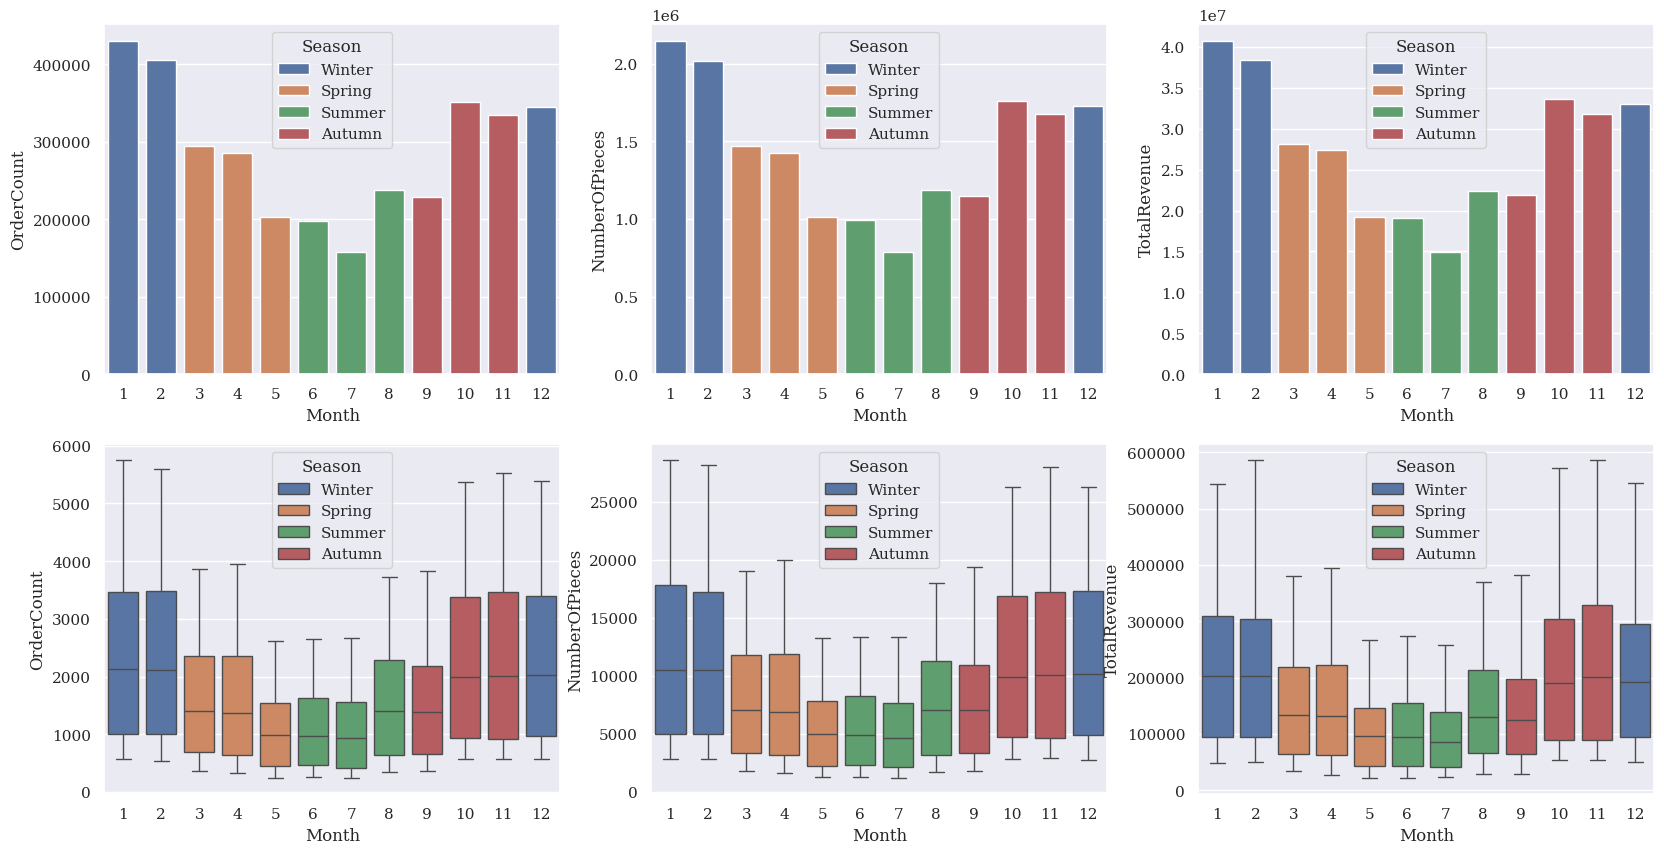

In [72]:
# Group by date of Season and by Month
df_bydate_month = df_bydate.groupby(by=['Month'],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_bydate_month['Season'] = df_bydate_month['Month'].map(keyLookup)
df_bydate_season = df_bydate.groupby(by=['Season'],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()

fig_bydate_month, ax_bydate_month = plt.subplots(2,3,figsize=(20,10))
sns.barplot(data = df_bydate_month, x = 'Month', y = 'OrderCount', ax = ax_bydate_month[0][0], hue = "Season")
sns.barplot(data = df_bydate_month, x = 'Month', y = 'NumberOfPieces', ax = ax_bydate_month[0][1], hue = "Season")
sns.barplot(data = df_bydate_month, x = 'Month', y = 'TotalRevenue', ax = ax_bydate_month[0][2], hue = "Season")

sns.boxplot(data=df_bydate, x='Month', y='OrderCount', ax = ax_bydate_month[1][0],hue="Season")
sns.boxplot(data=df_bydate, x='Month', y='NumberOfPieces', ax = ax_bydate_month[1][1],hue="Season")
sns.boxplot(data=df_bydate, x='Month', y='TotalRevenue', ax = ax_bydate_month[1][2],hue="Season")

<Axes: xlabel='Season', ylabel='TotalRevenue'>

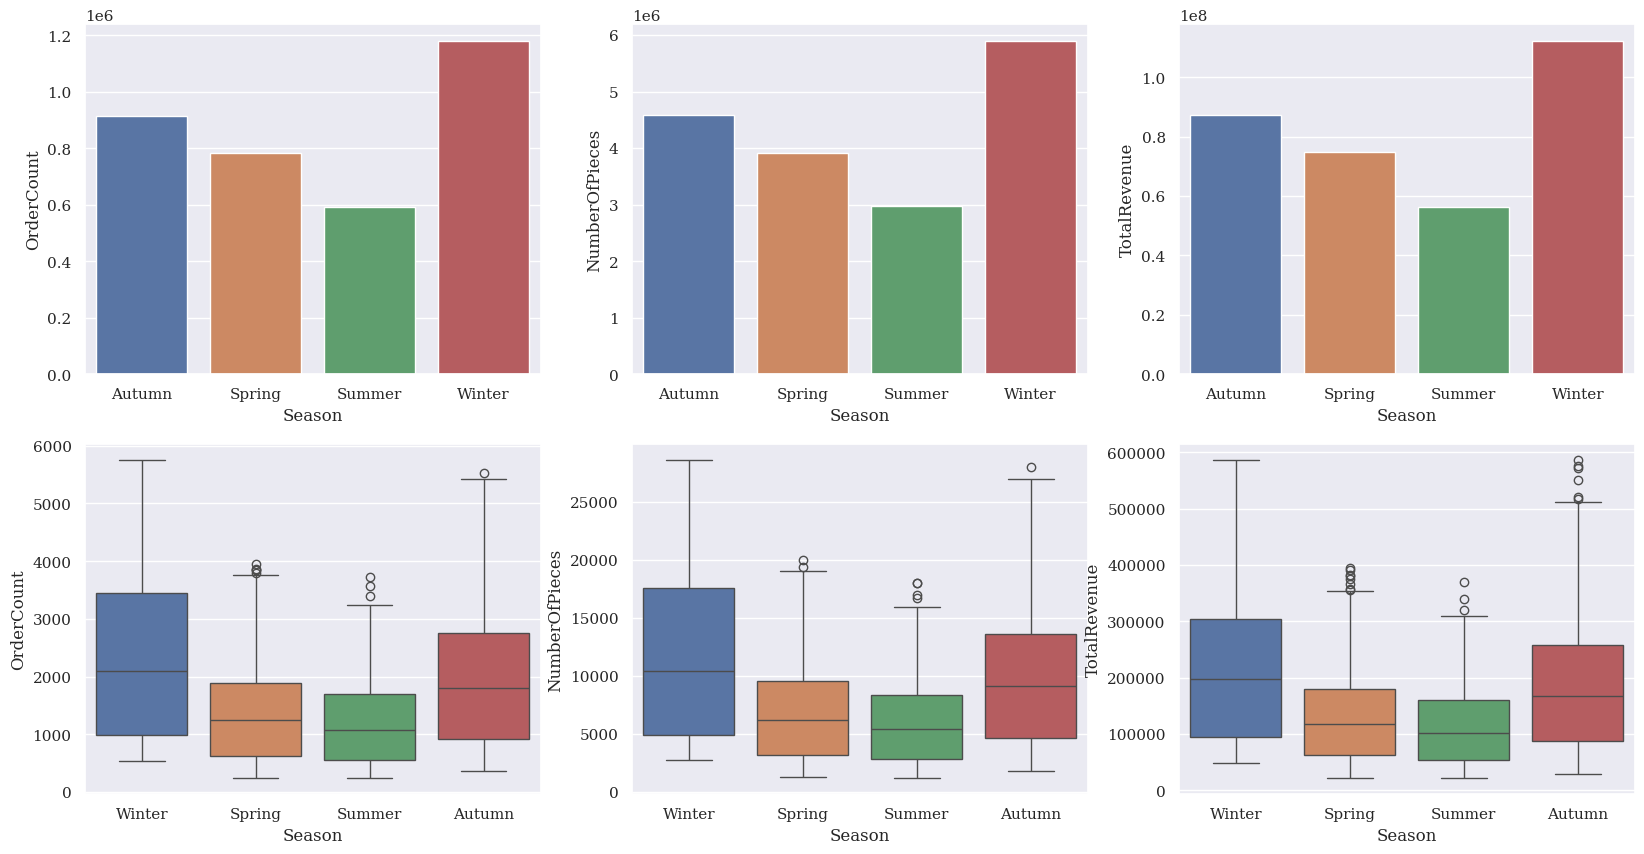

In [73]:
fig_bydate_season, ax_bydate_season = plt.subplots(2,3,figsize=(20,10))
sns.barplot(data = df_bydate_season, x = 'Season', y = 'OrderCount', ax = ax_bydate_season[0][0], hue = "Season")
sns.barplot(data = df_bydate_season, x = 'Season', y = 'NumberOfPieces', ax = ax_bydate_season[0][1], hue = "Season")
sns.barplot(data = df_bydate_season, x = 'Season', y = 'TotalRevenue', ax = ax_bydate_season[0][2], hue = "Season")

sns.boxplot(data=df_bydate, x='Season', y='OrderCount', ax = ax_bydate_season[1][0],hue="Season")
sns.boxplot(data=df_bydate, x='Season', y='NumberOfPieces', ax = ax_bydate_season[1][1],hue="Season")
sns.boxplot(data=df_bydate, x='Season', y='TotalRevenue', ax = ax_bydate_season[1][2],hue="Season")

These plots reflect again the yearly seasonal feature observed in the time series: The delivery becomes high during Oct-Feb (or Autumn-Winter), while it is less during the middle of the year (or Spring-Summer).

### 1f. OrderCount prediction with Prophet
First, let's fit the default Prophet model and make prediction

RMSE:  430.35031151445367
MAPE:  0.19588075000024663


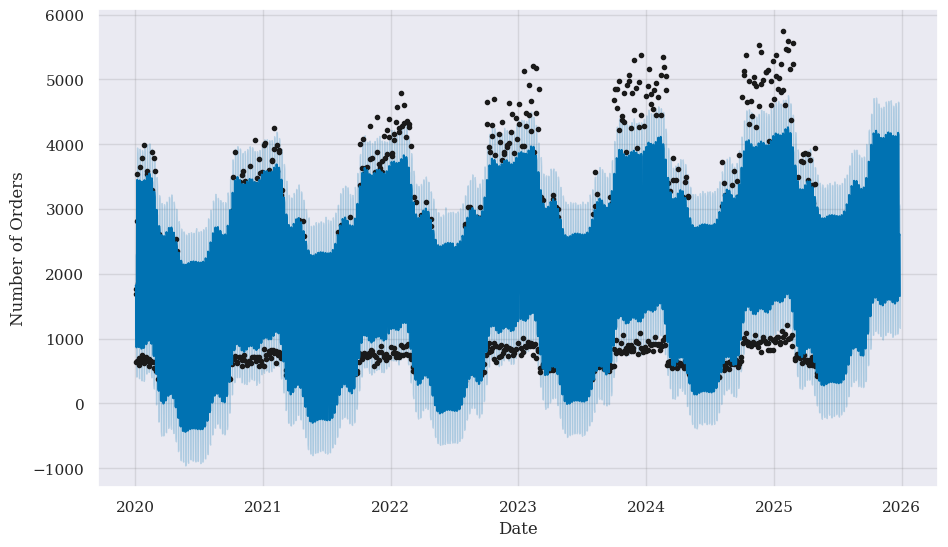

In [74]:
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
# prepare the data 
df_order = pd.DataFrame(df_bydate['OrderCount'])
df_order.reset_index(inplace=True)
df_order.columns = ['ds','y']

# Model fitting
model_raw = Prophet()
result_raw = model_raw.fit(df_order[['ds','y']])

# prediction and plot
future_dates_raw = model_raw.make_future_dataframe(periods=180, freq='D')
forecast_raw = model_raw.predict(future_dates_raw)

# cross validation and calculate two metrics RMSE and MAPE
df_raw_cv = cross_validation(model_raw, initial='730 days', period='90 days', horizon = '120 days', parallel="processes")
df_raw_p = performance_metrics(df_raw_cv, rolling_window=1)
print('RMSE: ',df_raw_p['rmse'].values[0])
print('MAPE: ',df_raw_p['mape'].values[0])

model_raw.plot(forecast_raw, uncertainty=True, xlabel='Date', ylabel='Number of Orders');

The fitting result shows two major problems:
>- firtsly, there are negative predictions, which should not be valid for the observable __OrderCount__.
>- secondly, the fitting result underestimates the peaks (and spikes). This behavior usually occurs for Prophet.

To remedy these two issues, we are going to change the *seasonality_mode* to *multiplicative* (instead of the default option *additive*) and change to the log scale. In addtion, we will perform a hyperparameter tuning using grid search with cross validation.

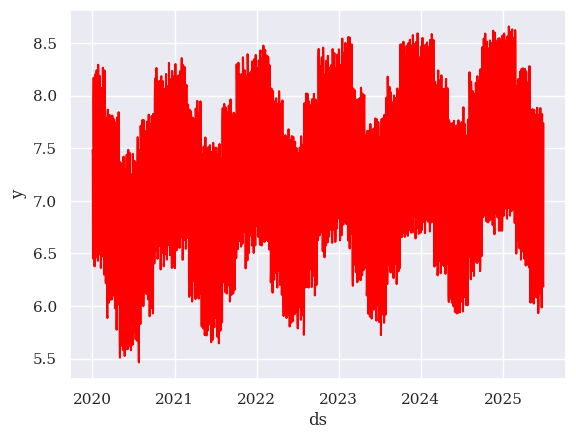

In [75]:
# log scale
df_order['exp_y'] = df_order['y']
df_order['y'] = np.log(df_order['y'])

sns.lineplot(data=df_order, x='ds', y='y',color='red')

# parameter space for tuning
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative'] 
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mape = []
for params in all_params:
    model = Prophet(**params).fit(df_order[['ds','y']])  # Fit model with given params
    df_cv = cross_validation(model, initial='730 days', period='90 days', horizon = '120 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mape.append(df_p['mape'].values[0])

# Find the tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mape

In [76]:
# Finding the best params base on RMSE
best_params_rmse = all_params[np.argmin(rmses)]
print('(RMSE) ', best_params_rmse)

# Finding the best params base on MAPE
best_params_mape = all_params[np.argmin(mape)]
print('(MAPE) ', best_params_mape)

# Model fittings using the best params
model_rmse = Prophet(**best_params_rmse)
model_mape = Prophet(**best_params_mape)

model_rmse.fit(df_order[['ds','y']])
model_mape.fit(df_order[['ds','y']])

# ... and predictions
future_dates_rmse = model_rmse.make_future_dataframe(periods=180, freq='D')
forecast_rmse = model_rmse.predict(future_dates_rmse)

future_dates_mape = model_mape.make_future_dataframe(periods=180, freq='D')
forecast_mape = model_mape.predict(future_dates_mape)

# Calculate the RMSE and MAPE (after back to normal scale) on the MAPE prediction
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape_mape = mean_absolute_percentage_error(df_order.exp_y, np.exp(forecast_mape.yhat[forecast_mape.ds<='2025-06-30']))
rmse_mape = np.sqrt(mean_squared_error(df_order.exp_y, np.exp(forecast_mape.yhat[forecast_mape.ds<='2025-06-30'])))
print("MAPE: ", mape_mape)
print("RMSE: ", rmse_mape)

(RMSE)  {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
(MAPE)  {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
MAPE:  0.08326106798402791
RMSE:  215.77000215663378


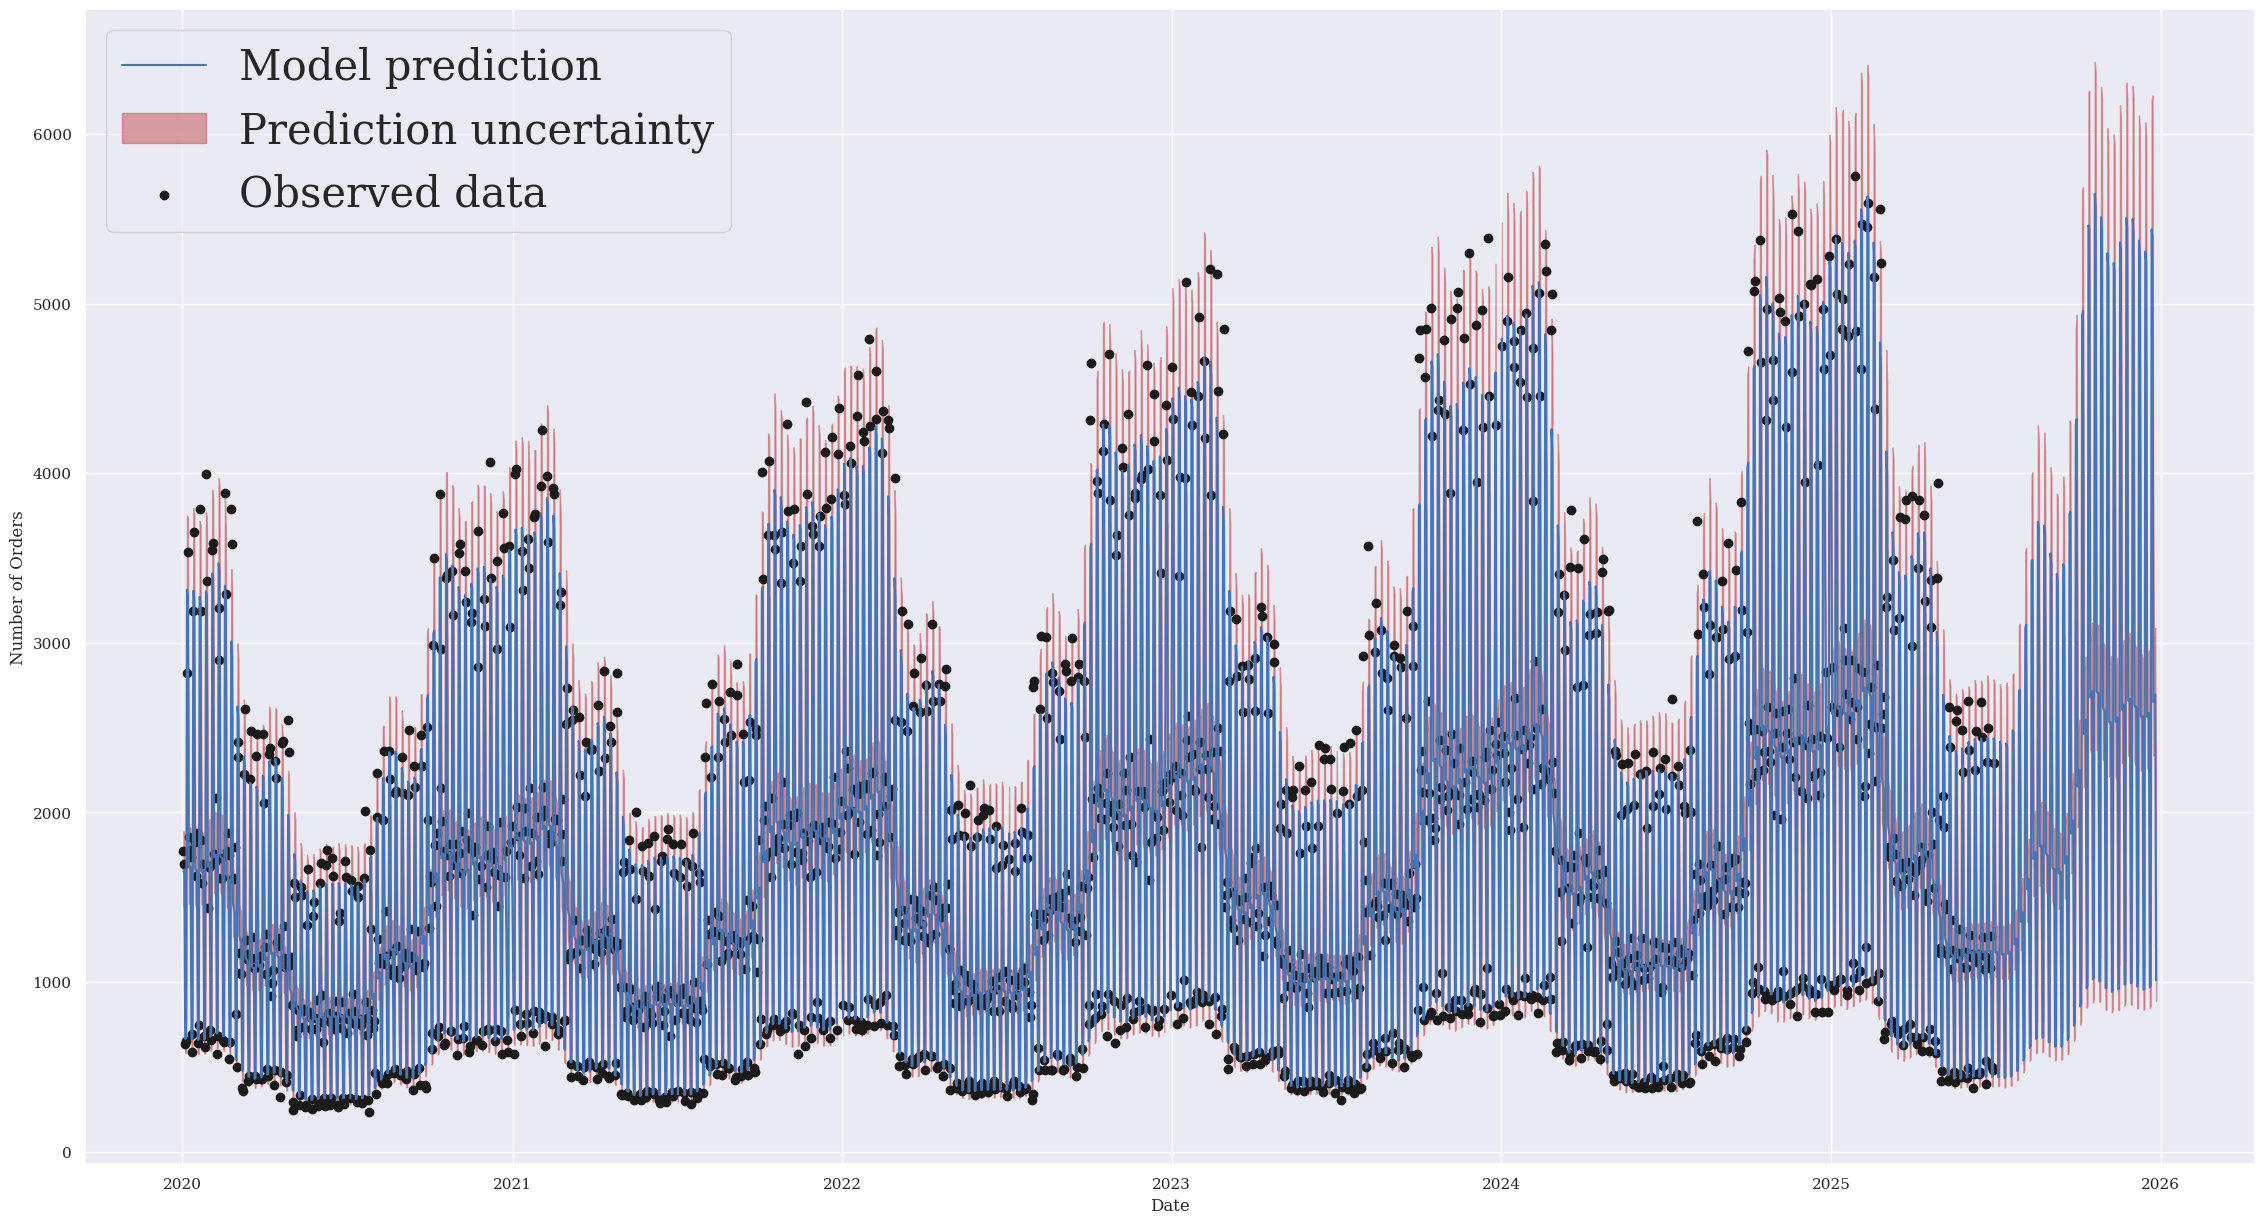

In [77]:
# plot the mape prediction by going back to the origin scale (instead of log scale)
plt.figure(figsize=(28,15))
plt.plot(forecast_mape.ds, np.exp(forecast_mape.yhat),'b-', label='Model prediction')
plt.fill_between(forecast_mape.ds, 
                 np.exp(forecast_mape.yhat_lower), 
                 np.exp(forecast_mape.yhat_upper), alpha=0.5, color='r',label='Prediction uncertainty')
plt.scatter(df_order.ds, df_order.exp_y, color='k', label='Observed data')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend(fontsize=30)

The prediction now is much better than the above raw prediction. This can be seen from the plot, and from the significant improvement in the correspong metrics:
>- MAPE: from 19.6% down to 8.3%
>- RMSE: from 430.4 down to 215.8

In [78]:
# print out some prediction dates
forecast_mape.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  additive_terms_upper      yhat
2162 2025-12-23  7.489897    8.465073    8.736655     7.489631     7.490216              0.147442                    0.147442                    0.147442  0.105664      0.105664      0.105664  0.041778      0.041778      0.041778             0.0                   0.0                   0.0  8.594222
2163 2025-12-24  7.490110    7.755873    8.021055     7.489841     7.490431              0.052379                    0.052379                    0.052379  0.009773      0.009773      0.009773  0.042606      0.042606      0.042606             0.0                   0.0                   0.0  7.882434
2164 2025-12-25  7.490322    7.757085    8.016483     7.490052     7.490646              0.053082                    0.053082                    0.053082  0.009611      0.009611      0.009611  0.043471      0.043471      0.043471             0.0                   0.0                   0.0  7.887923
2165 2025-12-26  7.490535    7.761272    8.035559     7.490262     7.490861              0.054557                    0.054557                    0.054557  0.010201      0.010201      0.010201  0.044356      0.044356      0.044356             0.0                   0.0                   0.0  7.899196
2166 2025-12-27  7.490747    6.790597    7.044647     7.490472     7.491076             -0.076491                   -0.076491                   -0.076491 -0.121736     -0.121736     -0.121736  0.045245      0.045245      0.045245             0.0                   0.0                   0.0  6.917771

## 2. Analyse the delivery dependence on customer, location and delivery stage
### 2a. Group data by date and by customer/location/stage

In [79]:
# Group by date and by customer
df_bydate_customer = df.groupby(by=["Customer","WorkDate"],as_index=True)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_customer = df.groupby(by=["Customer"],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_stage = df.groupby(by=["BusinessType"],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()
df_location = df.groupby(by=["Location"],as_index=False)[['OrderCount','NumberOfPieces','TotalRevenue']].sum()

In [80]:
# Delivery by Customer:
df_customer.head(15)

Customer  OrderCount  NumberOfPieces  TotalRevenue
0        Amazon      671676         3356220  5.045422e+07
1   Chick-Fil-A       79018          396738  4.379406e+06
2      Chipotle      180114          899729  1.030156e+07
3        Costco      271086         1359471  3.521400e+07
4    Home Depot      505821         2529865  1.163691e+08
5    Home Goods      225381         1123818  1.021177e+07
6         Lowes       82769          413056  1.556474e+07
7         Shein      245119         1228822  2.153992e+07
8     Starbucks      386705         1929417  2.267131e+07
9     T.J. Maxx      111693          558568  3.503744e+06
10       Target      531517         2659161  2.668533e+07
11      Walmart      179568          898616  1.384116e+07

In [81]:
# Delivery by location
df_location.head(20)

Location  OrderCount  NumberOfPieces  TotalRevenue
0         Atlanta      219463         1101257   27456873.45
1      Birmingham      113340          566069   10740701.07
2         Chicago      429386         2144276   51394495.41
3          Dallas      244647         1222191   21681355.09
4         Detroit      216466         1086727   15005180.28
5         Houston      199369          996924   19701446.95
6     Los Angeles      266435         1335060   30397400.66
7           Miami      103805          518629   10566428.91
8       Milwaukee      252329         1264699   17936431.50
9     Minneapolis       86924          435009   10667312.98
10      Nashville      205815         1023663   20568531.36
11       New York      184087          920125   11220516.73
12     Sacramento      209608         1048302   20832461.16
13      San Diego      170972          852148   10752488.18
14  San Francisco      208288         1042174   19367378.26
15        Seattle      138521          691410   12372777.04
16      Tampa Bay      221012         1104818   20074478.06

In [82]:
# Delivery by Delivery stage
df_stage.head()

BusinessType  OrderCount  NumberOfPieces  TotalRevenue
0   Final Mile     1519398         7595608  1.970690e+08
1   First Mile      271086         1359471  3.521400e+07
2  Middle Mile     1679983         8398402  9.845324e+07

### 2b. Comparison between groups 

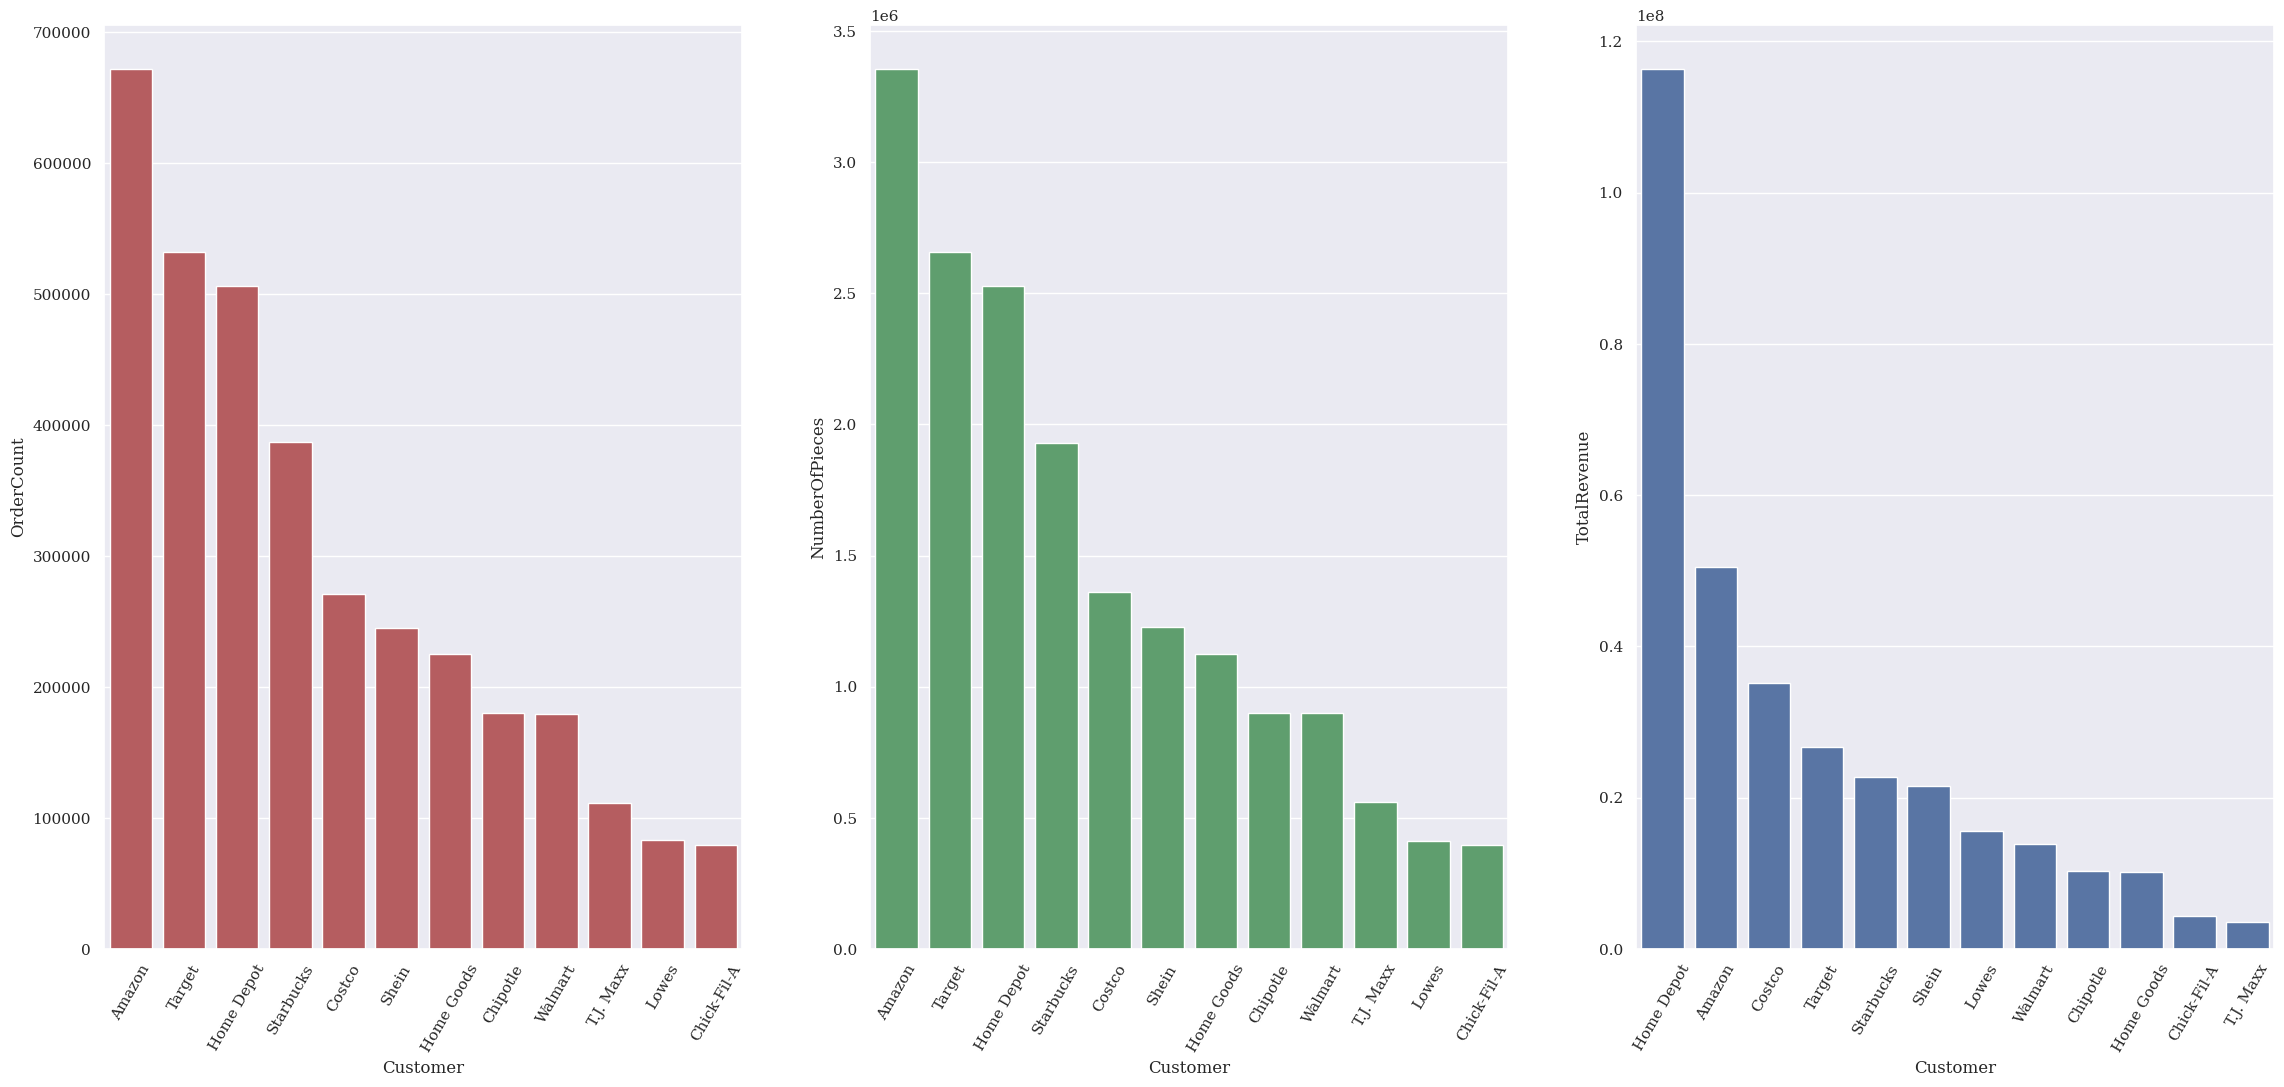

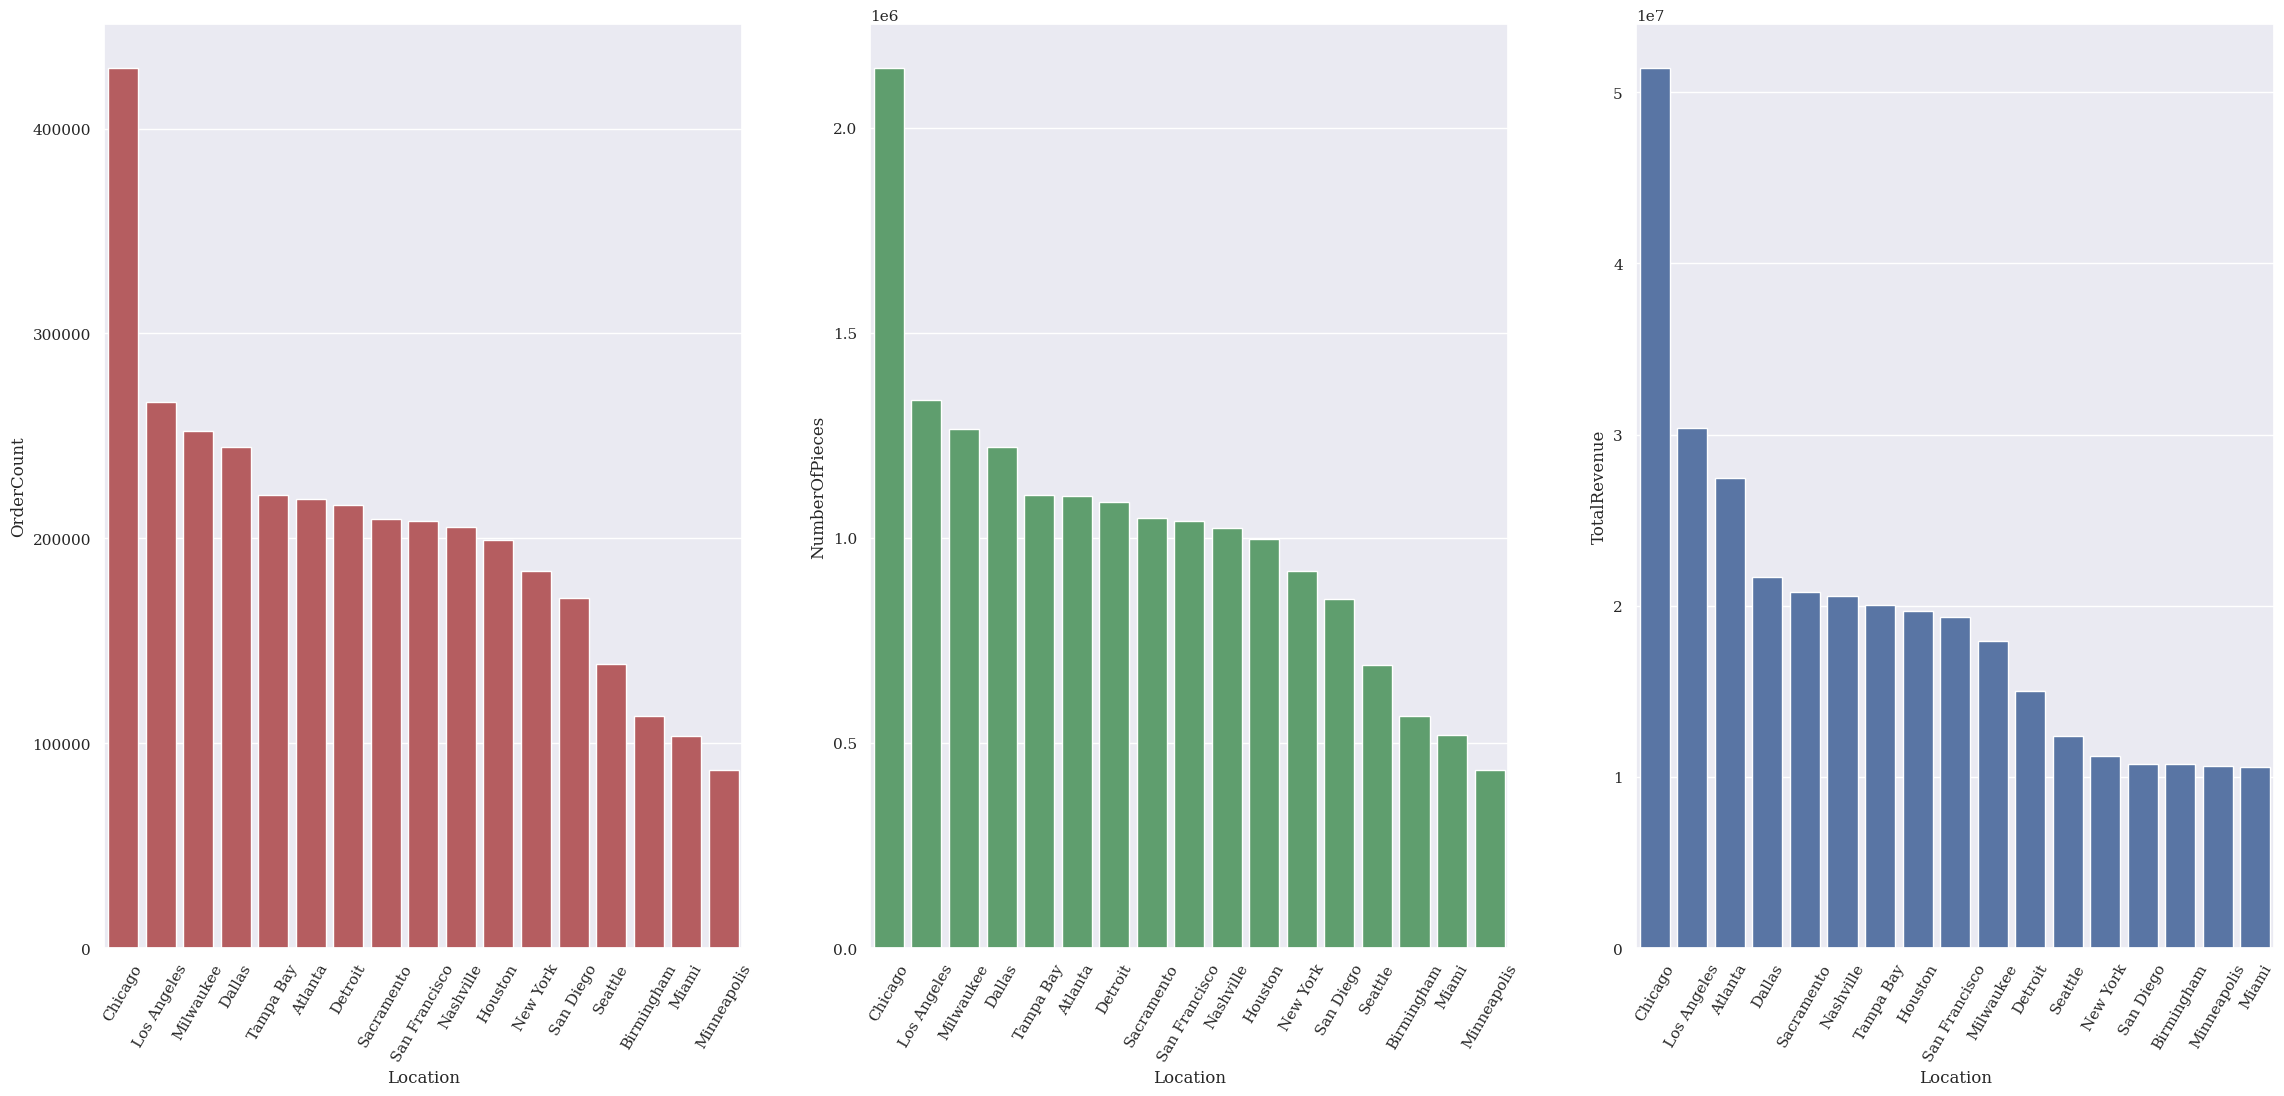

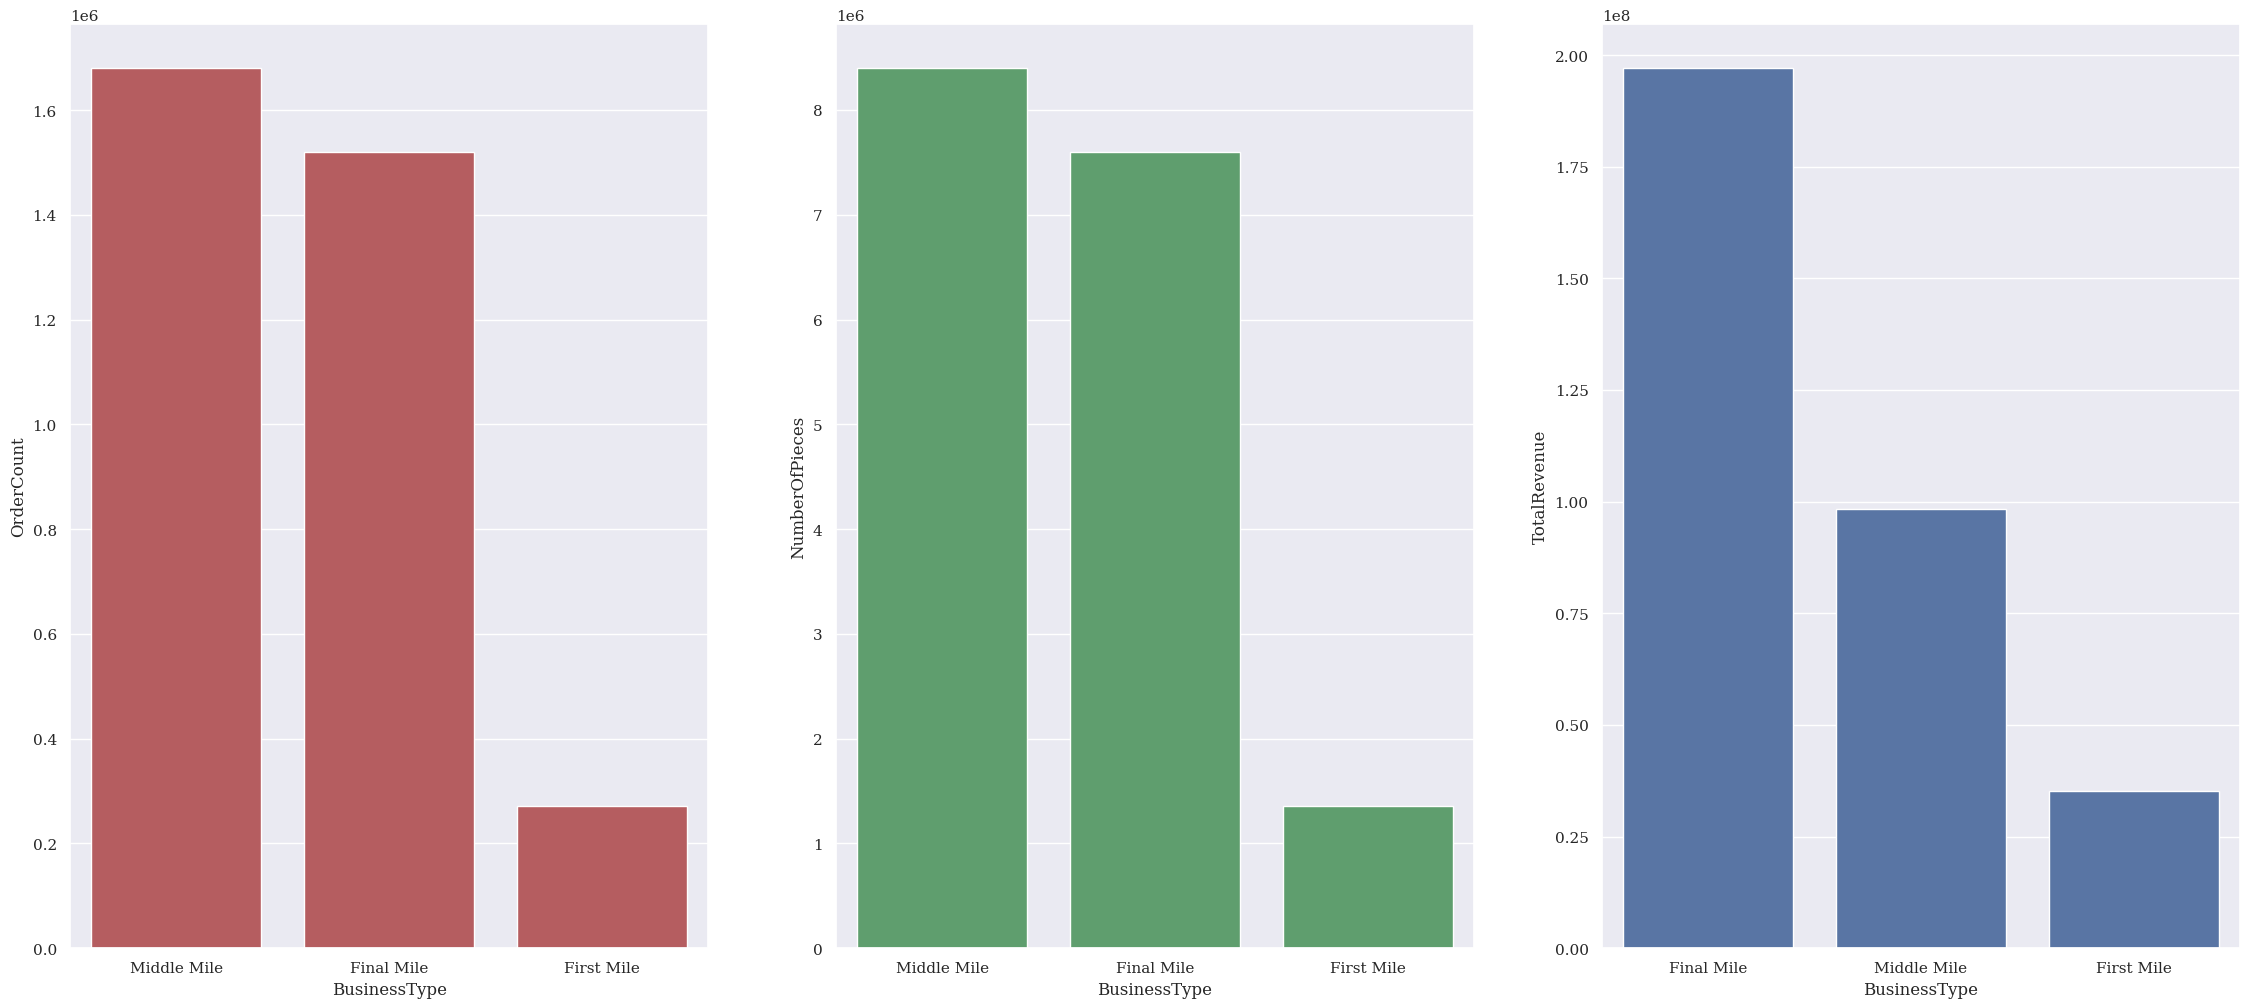

In [83]:
# plot distributions by customers
fig_customer_bar, ax_customer_bar = plt.subplots(1,3,figsize=(28,12))
sns.color_palette("rocket", as_cmap=True)
df_customer.sort_values('OrderCount',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_customer, x="Customer", y="OrderCount", ax=ax_customer_bar[0],color="r")
#
df_customer.sort_values('NumberOfPieces',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_customer, x="Customer", y="NumberOfPieces", ax=ax_customer_bar[1],color="g")
#
df_customer.sort_values('TotalRevenue',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_customer, x="Customer", y="TotalRevenue", ax=ax_customer_bar[2],color="b")
#
for i in range(3):
    ax_customer_bar[i].tick_params(axis='x', rotation=60)

# plot distributions by locations
fig_location_bar, ax_location_bar = plt.subplots(1,3,figsize=(28,12))

df_location.sort_values('OrderCount',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_location, x="Location", y="OrderCount", ax=ax_location_bar[0],color="r")
#
df_location.sort_values('NumberOfPieces',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_location, x="Location", y="NumberOfPieces", ax=ax_location_bar[1],color="g")
#
df_location.sort_values('TotalRevenue',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_location, x="Location", y="TotalRevenue", ax=ax_location_bar[2],color="b")
#
for i in range(3):
    ax_location_bar[i].tick_params(axis='x', rotation=60)

# plot distributions by stages
fig_stage_bar, ax_stage_bar = plt.subplots(1,3,figsize=(28,12))

df_stage.sort_values('OrderCount',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_stage, x="BusinessType", y="OrderCount", ax=ax_stage_bar[0],color="r")
#
df_stage.sort_values('NumberOfPieces',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_stage, x="BusinessType", y="NumberOfPieces", ax=ax_stage_bar[1],color="g")
#
df_stage.sort_values('TotalRevenue',ascending=False,inplace=True,ignore_index=True)
sns.barplot(data=df_stage, x="BusinessType", y="TotalRevenue", ax=ax_stage_bar[2],color="b")
#
for i in range(3):
    ax_stage_bar[i].tick_params(axis='x', rotation=0)

Comments:
> - **Customer**: _Amazon_ leads in the number of orders, which is followed by _Target_ and _Home Depot_. The different between _Amazon_ and _Target_ and _Home Depot_ is not so drastically. However, in the total revenue aspect, _Home Depot_ is the leading customer, and the difference between it and the second place (_Amazon_) is remarkably (more than 2 times different).
> - **Location**: Chicago is the leading city in delivery statistics, which is significant larger than other cities.  
> - **Business Type (Delivery Stage)**: _Middle Mile_ and _Final Mile_ dominate over the _First Mile_ in both number of orders and total revenue. While the number of orders of _Middle Mile_ and _Final Mile_ are comparable, _Final Mile_ has a significant larger (~2 times) total revenue than _Middle Mile_.

### 2c. Bonus: Time series for each customer

GridSpec(6, 2)[5:6, 1:2]


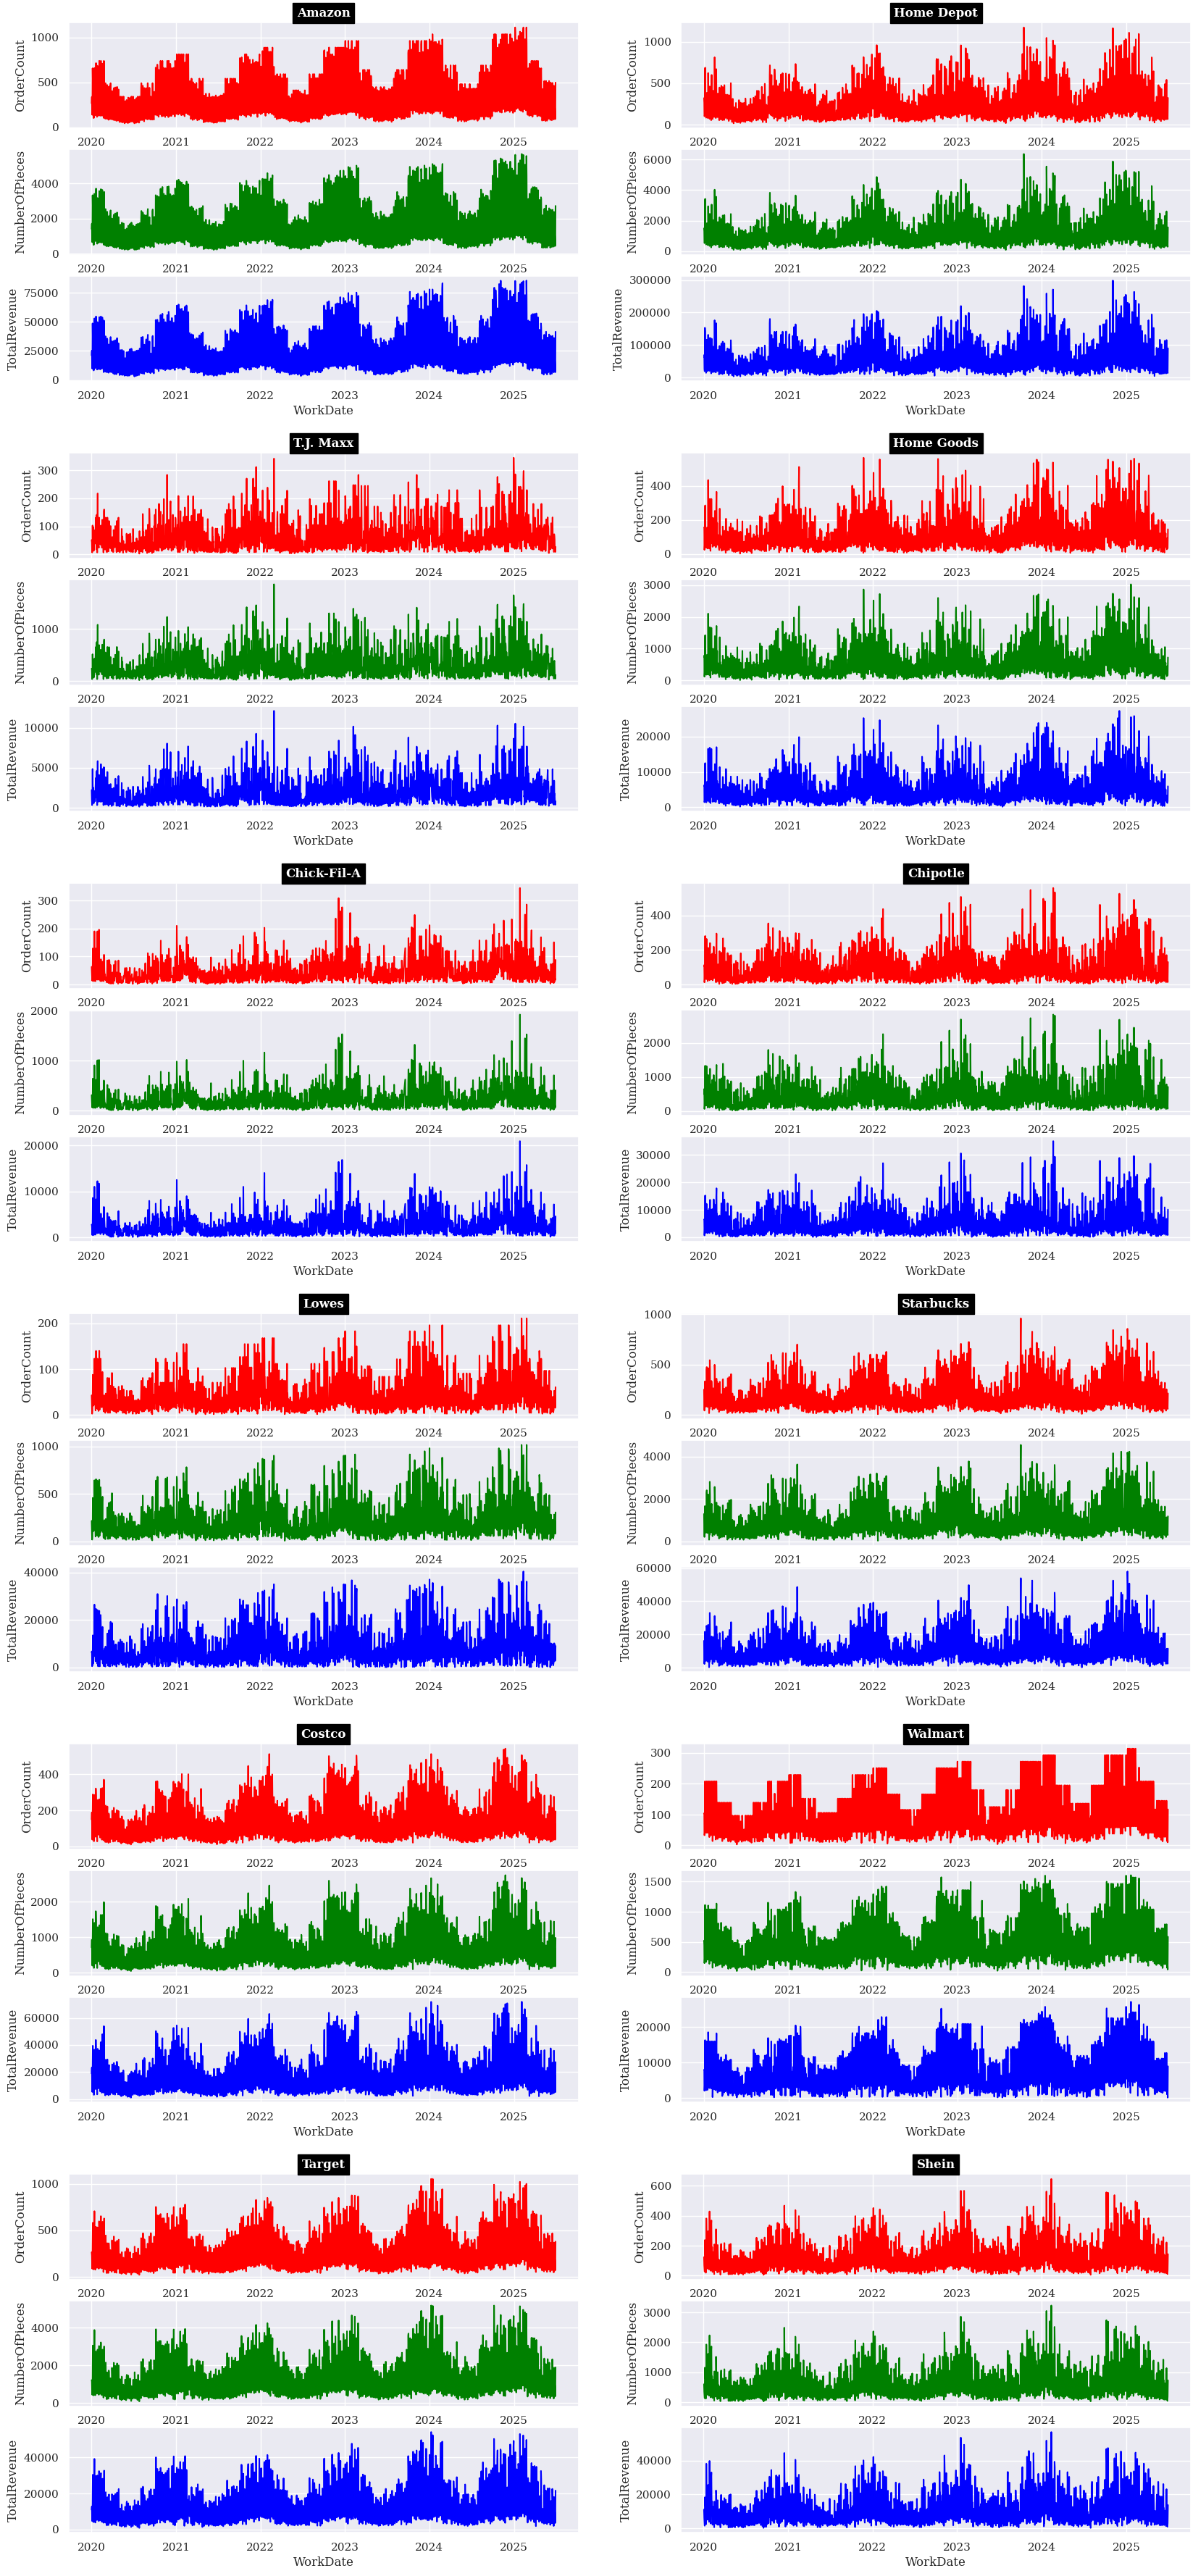

In [84]:
import matplotlib.gridspec as gridspec
customers_ts = [None for i in range(len(customers))]
total_missing_values_bycustomer = [None for i in range(len(customers))]
missing_date = [None for i in range(len(customers))]
for i in range(len(customers)):
    customers_ts[i] = pd.DataFrame(df_bydate_customer.loc[(customers[i])])
    customers_ts[i].resample('1D').mean()
    total_missing_values_bycustomer[i] = customers_ts[i]['TotalRevenue'].isnull().sum()
    missing_date[i] = customers_ts[i][customers_ts[i].isna().any(axis=1)].index
    #customers_ts[i].interpolate(method='linear', inplace=True, limit_direction='both')


fig_customer_ts = plt.figure(figsize=(20,45))
ax_customer_ts = [None for i in range(12)]
gs_out = gridspec.GridSpec(6, 2, figure=fig_customer_ts)
print(gs_out[11])
gs_in = [None for i in range(12)]
for i in range(len(customers)):
    gs_in[i] = gs_out[i].subgridspec(3, 1)
    ax_customer_ts[i] = [fig_customer_ts.add_subplot(gs_in[i][j, 0]) for j in range(3)]
    ax_customer_ts[i][0].set_title(customers[i],backgroundcolor='black', color='white', fontweight="bold")
    sns.lineplot(data=customers_ts[i], x=customers_ts[i].index, y='OrderCount',color='red',ax=ax_customer_ts[i][0])
    sns.lineplot(data=customers_ts[i], x=customers_ts[i].index, y='NumberOfPieces',color='green',ax=ax_customer_ts[i][1])
    sns.lineplot(data=customers_ts[i], x=customers_ts[i].index, y='TotalRevenue',color='blue',ax=ax_customer_ts[i][2])

### 2d. Bonus: Anomaly detection for each customer
We now care about the demand spikes for each customers, based on the number of order. We use the MSTL with three sigmas threshold as before.

In [85]:
customer_decompose_res = [MSTL(c['OrderCount'], periods = [7,365]).fit() for c in customers_ts]

In [86]:
customer_order_resid_mean = np.array([cdr.resid.mean() for cdr in customer_decompose_res])
customer_order_resid_std = np.array([cdr.resid.std() for cdr in customer_decompose_res])
customer_order_lbound = customer_order_resid_mean - threshold*customer_order_resid_std
customer_order_ubound = customer_order_resid_mean + threshold*customer_order_resid_std

In [87]:
custormer_order_anomalies = []
for i in range(len(customers_ts)):
    tmp = customers_ts[i]['OrderCount'][
    (customer_decompose_res[i].resid < customer_order_lbound[i]) | (customer_decompose_res[i].resid > customer_order_ubound[i])]
    custormer_order_anomalies.append(tmp)

In [88]:
# To printout, uncommented the following lines
#for c in custormer_order_anomalies:
#    print(c.index)

_By_: **Anh Dung Le**

_Porfolio Project_: **Data Analytics**

_Topic_: **Time-series analysis** 